In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from termcolor import colored
import seaborn as sns
sns.set(style = 'darkgrid')
from collections import Counter
%matplotlib inline

### Creating in-game Functions

In [3]:
def draw_hand(actual_deck):
    """
    This code will draw 2 cards randomly from the deck specified, and remove the cards drew from the deck.
    This function will return a list of 2 cards i.e. ['K',8]
    """
    
    hand = []
    for i in range(2):
        rand_ = random.randint(0,len(actual_deck)-1)
        hand.append(actual_deck[rand_])
        actual_deck.pop(rand_)
    return hand

def draw_card(actual_deck, hand):
    """
    This function will draw one card randomly from the deck. Use when "HIT" action is activated. It will also remove the card drew from the deck.
    This function will take input of card deck and the existing hand, and return new list of cards.
    """
    rand_ = random.randint(0,len(actual_deck)-1)
    hand.append(actual_deck[rand_])
    actual_deck.pop(rand_)
    return hand

def calculate_pts(card_lst):
    """
    This function calculates the total number of points, based on the cards on hand. It will take into consideration on usable Ace.
    This will return you a list of points. 
    If there is usable ace, it will return you list of 2 points (min and max) i.e. [10,20].
    If there is no usable ace, it will return you list of 1 point i.e. [15]
    """
       
    pts = 0
    pts_lst = []
    for card in card_lst:
        if str(card) in "JQK":
            pts += 10
        elif type(card) == int:
            pts += card
        elif str(card) == "A":
            pts += 1
    pts_lst.append(pts) #min_point
    
    #explore max points that is within 21. Exceeding 21 will not be considered.
    count = card_lst.count("A")
    if len(card_lst) >= 4:
        pass
    else:
        for i in range(count):
            pts = pts + (i+1)*10
            if pts > 21:
                pass
            else:
                pts_lst.append(pts)
    return pts_lst

def compare(player_pts, dealer_pts):
    """
    This function compares between player point and dealer point and return the result.
    For result, 0 is draw; 1 is player win; -1 is player lost.
    """
    # 0 - draw / 1 - player win / -1 - player lost
    if (21-dealer_pts <0 and 21-player_pts <0) or dealer_pts == player_pts:
        return 0
    elif (21-dealer_pts >= 0 and 21-player_pts <0): #dealer positive and player negative: player lost
        return -1
    elif (21-dealer_pts < 0 and 21-player_pts >= 0): #dealer negative and player positive: player won
        return 1
    else:
        return (player_pts > dealer_pts) - (player_pts < dealer_pts) 

def display_pts(play_pts):
    """
    This function will display the points based on the card on hand.
    """
    if len(play_pts)>1:
        print(f"You have total of {play_pts[0]} or {play_pts[1]}.")
    else: 
        print(f"You have total of {play_pts[0]}.")

### Reinforced Learning Parameters

In [6]:
class Blackjack():

    # for reinforced learning - Q value storage
    def __init__(self, lr=0.1, exp_rate=0.3):
        self.player_Q_Values = {}  # key: [(player_value, show_card, usable ace)][action] = value
        # initialise Q values | (15-21) x (1-10) x (1, 0)
        for i in range(11, 22):
            for j in range(1, 11):
                for k in [True,False]:
                    self.player_Q_Values[(i, j, k)] = {}
                    for a in [1, 0]:
                        if (i == 21) and (a == 0):
                            self.player_Q_Values[(i, j, k)][a] = 1
                        else:
                            self.player_Q_Values[(i, j, k)][a] = 0

        self.full_deck = []
        self.player_state_action = []
        self.state = (0, 0, False)  # initial state
        self.actions = [1, 0]  # 1: HIT  0: STAND
        self.last_action = 0
        self.end_turn = False
        self.player_multi = 0
        self.player_natwin = False
        self.dealer_multi = 0
        self.dealer_natwin = False
        self.end_game = False
        self.lr = lr
        self.exp_rate = exp_rate
    
    # reset all game state to default. Need to trigger on every new game
    def reset(self):
        self.player_state_action = []
        self.state = (0, 0, False) # initial state
        self.last_action = 0
        self.end_turn = False
        self.player_multi = 0
        self.player_natwin = False
        self.dealer_multi = 0
        self.dealer_natwin = False
        self.end_game = False
    
    # construct a deck
    def build_deck(self):
        picture = "AJQK"
        
        for i in range(0,4):
            for j in range(0,9):
                self.full_deck.append(j+2)
            
            for k in picture:
                self.full_deck.append(k)
        random.shuffle(self.full_deck)
    
    
    # determine if there is a natural win for player, either during start of the game or during card drawing
    def natural_win_player(self, player_deck):
        banluck = [['A',i] for i in ['J','Q','K',10]]
        banluck.extend([[i, 'A'] for i in ['J','Q','K',10]])
        triple_7 = [7,7,7]
        for i in banluck:
            if i == player_deck:
                print("You got Ban Luck!")
                self.player_multi = 2
                self.player_natwin = True
                self.end_game = True
        if player_deck == ['A','A']:
            print("You got Ban Ban!")
            self.player_multi = 3
            self.player_natwin = True
            self.end_game = True
        elif player_deck == triple_7:
            print("You got Triple 7!")
            self.player_multi = 7
            self.player_natwin = True
            self.end_game = True
        elif len(player_deck)==5 and min(calculate_pts(player_deck)) <= 21:
            print("You got Dragon!")
            self.player_multi = 2
            self.player_natwin = True
            self.end_game = True
    
    # determine if there is a natural win for dealer, either during start of the game or during card drawing
    def natural_win_dealer(self, dealer_deck):
        banluck = [['A',i] for i in ['J','Q','K',10]]
        banluck.extend([[i, 'A'] for i in ['J','Q','K',10]])
        triple_7 = [7,7,7]
        for i in banluck:
            if i == dealer_deck:
                print("Dealer got Ban Luck!")
                self.dealer_multi = 2
                self.dealer_natwin = True
                self.end_game = True
        if dealer_deck == ['A','A']:
            print("Dealer got Ban Ban!")
            self.dealer_multi = 3
            self.dealer_natwin = True
            self.end_game = True
        elif dealer_deck == triple_7:
            print("Dealer got Triple 7!")
            self.dealer_multi = 7
            self.dealer_natwin = True
            self.end_game = True
        elif len(dealer_deck)==5 and min(calculate_pts(dealer_deck)) <= 21:
            print("Dealer got Dragon!")
            self.dealer_multi = 2
            self.dealer_natwin = True
            self.end_game = True 
    
    # To use with natural_win_player/dealer function.
    # To cover the case when there are 2 natural winning cases occur.
    # This function will compare who is the winner from both natural wins.
    def natural_winner(self, bid):
        if self.player_multi > self.dealer_multi:
            payout = bid*(self.player_multi - self.dealer_multi)
            print(f"YOU WON! ${payout} to your stash.")
        elif self.player_multi < self.dealer_multi:
            payout = bid*(self.player_multi - self.dealer_multi)
            print(f"YOU LOST! ${payout} to your stash.")
        elif self.player_natwin and self.dealer_natwin:
            payout = 0
            print("IT IS A DRAW!")
        return payout
    
    # This function will print text based on the winning result and bid price
    def winner(self, result, bid):
        if result == 1:
            print(f"YOU WON! ${bid} to your stash.")
            return bid
        elif result == -1:
            print(f"YOU LOST! ${-bid} to your stash.")
            return -bid
        else:
            print("IT IS A DRAW!")
            return 0
        
    # This function is for reinforcement learning. Model will use this to choose action between HIT or STAND.
    # 1 is HIT and 0 is STAND
    # To let model choose completely random action, set exp_rate to 1, else 0 (or x to random for x% of the time)
    def chooseAction(self):
        # if current value <= 11, always hit
        current_value = self.state[0]
        if current_value <= 15:
            return 1

        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
            print("random action", action)
        else:
            # greedy action
            v = -999
            action = 0
            for a in self.player_Q_Values[self.state]:
                if self.player_Q_Values[self.state][a] > v:
                    action = a
                    v = self.player_Q_Values[self.state][a]
                    print("greedy action", action)
        return action
    
    def _giveCredit(self, player_pts, dealer_pts):
        reward = compare(player_pts, dealer_pts)
        # backpropagate reward
        for s in reversed(self.player_state_action):
            state, action = s[0], s[1]
            reward = self.player_Q_Values[state][action] + self.lr*(reward - self.player_Q_Values[state][action]) #+ 0.1*((reward-1)/2*reward*self.lr*abs(21-player_pts)) #changed
            self.player_Q_Values[state][action] = round(reward, 3)

### Train Q Value for 10000 Games

This project will showcase Reinforcement Learning to increase the winning odds while playing with bot with prefixed policy.
It uses 3 environment states:
- player's value
- dealer's show card (one of two hand cards)
- usable ace on player's hand

Result will be whether to hit or stand, in this case, hit is 1 and stand is 0.
This is how the default Q-values look like:

In [7]:
player = Blackjack()
player.player_Q_Values

{(11, 1, True): {1: 0, 0: 0},
 (11, 1, False): {1: 0, 0: 0},
 (11, 2, True): {1: 0, 0: 0},
 (11, 2, False): {1: 0, 0: 0},
 (11, 3, True): {1: 0, 0: 0},
 (11, 3, False): {1: 0, 0: 0},
 (11, 4, True): {1: 0, 0: 0},
 (11, 4, False): {1: 0, 0: 0},
 (11, 5, True): {1: 0, 0: 0},
 (11, 5, False): {1: 0, 0: 0},
 (11, 6, True): {1: 0, 0: 0},
 (11, 6, False): {1: 0, 0: 0},
 (11, 7, True): {1: 0, 0: 0},
 (11, 7, False): {1: 0, 0: 0},
 (11, 8, True): {1: 0, 0: 0},
 (11, 8, False): {1: 0, 0: 0},
 (11, 9, True): {1: 0, 0: 0},
 (11, 9, False): {1: 0, 0: 0},
 (11, 10, True): {1: 0, 0: 0},
 (11, 10, False): {1: 0, 0: 0},
 (12, 1, True): {1: 0, 0: 0},
 (12, 1, False): {1: 0, 0: 0},
 (12, 2, True): {1: 0, 0: 0},
 (12, 2, False): {1: 0, 0: 0},
 (12, 3, True): {1: 0, 0: 0},
 (12, 3, False): {1: 0, 0: 0},
 (12, 4, True): {1: 0, 0: 0},
 (12, 4, False): {1: 0, 0: 0},
 (12, 5, True): {1: 0, 0: 0},
 (12, 5, False): {1: 0, 0: 0},
 (12, 6, True): {1: 0, 0: 0},
 (12, 6, False): {1: 0, 0: 0},
 (12, 7, True): {1: 0,

Instead of interactive game environment, I have replaced the human-inputs to auto, and let it train for 10,000 games.
First, we will set the starting total chips to be 1,000,000 dollar. Each bid will be 100 dollar for training for now, so that we don't run out of money during the training.

I'm setting player.exp_rate to 1 so that it gets complete random action, with learning rate of 0.1. See Blackjack.chooseAction for more details.

In [18]:
vers = 2.00
player = Blackjack()
player.build_deck()
actual_deck = player.full_deck.copy()
player.reset()
player.lr = 0.1
player.exp_rate = 1 #do completely random action

# for Data collection
total_chips = [1000000] #starting
bid_lst = [0]
LnP = [0]
player_pts_lst = [0]
deal_pts_lst = [0]

print(f"$$$ You have starting cash of ${total_chips[-1]}")

for i in range(0,10000):
    player.reset()
    # DECK SHUFFLE - only shuffle when 70% of card is consumed
    if len(actual_deck)/52 <= 0.3:
        random.shuffle(player.full_deck)
        actual_deck = player.full_deck.copy()   
    else: random.shuffle(actual_deck)   
    
    # Bidding input verification
    #bid = input("How much do you want to bid? : ")
    bid = "100"
    while sum([ 1 for j in bid if j not in "0123456789"])>0:
        print("Please enter valid integer.")
        bid = input("How much do you want to bid? : ")
        continue
    bid = eval(bid)
    while bid > total_chips[-1]:
        print("You have no money...")
        bid = input("How much do you want to bid? : ")
        bid = eval(bid)
        continue
    bid_lst.append(bid)
    
    print("\n")
    print(f"************************** Round {i+1} **************************")
    print(f"$$$ You have bidded ${bid}!")
    print(f"$$$ You have remaining ${total_chips[-1] - bid_lst[-1]}!")
    print("\n")
    print(colored("--- Player's Turn ---", 'blue'))
    player_hand = draw_hand(actual_deck)
    dealer_hand = draw_hand(actual_deck)
    play_pts = calculate_pts(player_hand)
    deal_pts = calculate_pts(dealer_hand)
    print(f"You got: {player_hand}")
    
    player.state = max(play_pts), dealer_hand[0] if type(dealer_hand[0]) == int else min(calculate_pts(dealer_hand[0])),True if len(play_pts)>1 else False
    
    # Check for Natural Win
    player.natural_win_player(player_deck = player_hand)
    player.natural_win_dealer(dealer_deck = dealer_hand)
    if player.end_game == True:
        pay = player.natural_winner(bid)
        total_chips.append(total_chips[-1]+pay)
        LnP.append(pay)
        player_pts_lst.append(min(play_pts)) # data collection
        deal_pts_lst.append(min(play_pts)) # data collection
        continue
        
    # Continue if no Natural Win
    # ------------------------------- PLAYER TURN ----------------------------------
    if not player.end_game:
        play_pts = calculate_pts(player_hand)
        display_pts(play_pts)   
        
        action = player.chooseAction()
        if max(play_pts)>11:
            player.player_state_action.append([player.state, action])

        while action and min(play_pts)<=21 and not player.end_turn:
            player_hand = draw_card(actual_deck,player_hand)
            play_pts = calculate_pts(player_hand)
            print(f"You got: {player_hand}")
            display_pts(play_pts)
            player.natural_win_player(player_deck = player_hand)
            if player.end_game == True:
                pay = player.natural_winner(bid)
                break
            if max(play_pts)<=21:
                player.state = max(play_pts), dealer_hand[0] if type(dealer_hand[0]) == int else min(calculate_pts(dealer_hand[0])),True if len(play_pts)>1 else False
                action = player.chooseAction()
        
    # ------------------------------- DEALER TURN ----------------------------------
    if not player.end_game:
        print(colored("--- Dealer's Turn ---", 'red'))      
        while max(deal_pts) < 17 and len(dealer_hand)<5:
            dealer_hand = draw_card(actual_deck,dealer_hand)
            print("Dealer drew a card...")
            deal_pts = calculate_pts(dealer_hand)
            player.natural_win_dealer(dealer_deck = dealer_hand)
            if player.end_game == True:
                pay = player.natural_winner(bid)
                break
        
        play_pts = max(play_pts)
        deal_pts = max(deal_pts)
        print(f"Dealer got : {dealer_hand}")
        print(f"Dealer have total of {deal_pts}.")
        print("\n")
        result = compare(play_pts, deal_pts)
        pay = player.winner(result, bid)
        player.end_game = True
        print("\n")
    
    play_pts = max(calculate_pts(player_hand))
    deal_pts = max(calculate_pts(dealer_hand))
    LnP.append(pay)
    total_chips.append(total_chips[-1]+pay)
    player_pts_lst.append(play_pts) # data collection
    deal_pts_lst.append(deal_pts) # data collection

    if not player.player_natwin or not player.dealer_natwin:
        player._giveCredit(play_pts, deal_pts)
   
    #cont_ = input("Continue to next round? Y/N :")
    cont_ = 'y'
    while cont_.lower() not in "yn":
        print("Invalid input. Please enter Y/N.")
        cont_ = input("Continue to next round? Y/N :")   
    if cont_.lower() == 'y':
        continue
    elif cont_.lower() == 'n':
        print("Game ended.")
        # see result
        break

$$$ You have starting cash of $1000000


************************** Round 1 **************************
$$$ You have bidded $100!
$$$ You have remaining $999900!


--- Player's Turn ---
You got: [10, 'Q']
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['J', 5, 'J']
Dealer have total of 25.


YOU WON! $100 to your stash.




************************** Round 2 **************************
$$$ You have bidded $100!
$$$ You have remaining $1000000!


--- Player's Turn ---
You got: ['A', 'J']
You got Ban Luck!
YOU WON! $200 to your stash.


************************** Round 3 **************************
$$$ You have bidded $100!
$$$ You have remaining $1000200!


--- Player's Turn ---
You got: [4, 'Q']
You have total of 14.
You got: [4, 'Q', 'J']
You have total of 24.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [10, 4, 5]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 4 ******************

--- Player's Turn ---
You got: [9, 8]
Dealer got Ban Luck!
YOU LOST! $-200 to your stash.


************************** Round 105 **************************
$$$ You have bidded $100!
$$$ You have remaining $997100!


--- Player's Turn ---
You got: [2, 6]
You have total of 8.
You got: [2, 6, 8]
You have total of 16.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [6, 7, 7]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 106 **************************
$$$ You have bidded $100!
$$$ You have remaining $997000!


--- Player's Turn ---
You got: [7, 2]
You have total of 9.
You got: [7, 2, 'A']
You have total of 10 or 20.
random action 0
--- Dealer's Turn ---
Dealer got : ['K', 'Q']
Dealer have total of 20.


IT IS A DRAW!




************************** Round 107 **************************
$$$ You have bidded $100!
$$$ You have remaining $997000!


--- Player's Turn ---
You got: [3, 4]
You have total of 7.
You got: [3, 4, '

You have total of 12.
You got: [4, 8, 9]
You have total of 21.
random action 0
--- Dealer's Turn ---
Dealer got : ['A', 8]
Dealer have total of 19.


YOU WON! $100 to your stash.




************************** Round 187 **************************
$$$ You have bidded $100!
$$$ You have remaining $995900!


--- Player's Turn ---
You got: ['K', 8]
You have total of 18.
random action 1
You got: ['K', 8, 'A']
You have total of 19.
random action 1
You got: ['K', 8, 'A', 'Q']
You have total of 29.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [10, 2, 5]
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 188 **************************
$$$ You have bidded $100!
$$$ You have remaining $995800!


--- Player's Turn ---
You got: [4, 2]
You have total of 6.
You got: [4, 2, 'J']
You have total of 16.
random action 0
--- Dealer's Turn ---
Dealer got : [10, 9]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** 

You got: [4, 3, 2]
You have total of 9.
You got: [4, 3, 2, 4]
You have total of 13.
You got: [4, 3, 2, 4, 8]
You have total of 21.
You got Dragon!
YOU WON! $200 to your stash.


************************** Round 270 **************************
$$$ You have bidded $100!
$$$ You have remaining $993700!


--- Player's Turn ---
You got: ['A', 8]
You have total of 9 or 19.
random action 1
You got: ['A', 8, 9]
You have total of 18.
random action 1
You got: ['A', 8, 9, 10]
You have total of 28.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [6, 'Q', 3]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 271 **************************
$$$ You have bidded $100!
$$$ You have remaining $993600!


--- Player's Turn ---
You got: [5, 5]
You have total of 10.
You got: [5, 5, 'J']
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [5, 'Q', 9]
Dealer have total of 24.


YOU WON! $100 to your stash.




******

--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['J', 5, 'Q']
Dealer have total of 25.


YOU WON! $100 to your stash.




************************** Round 352 **************************
$$$ You have bidded $100!
$$$ You have remaining $991000!


--- Player's Turn ---
You got: ['Q', 'K']
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer got : [7, 'K']
Dealer have total of 17.


YOU WON! $100 to your stash.




************************** Round 353 **************************
$$$ You have bidded $100!
$$$ You have remaining $991100!


--- Player's Turn ---
You got: [2, 9]
You have total of 11.
You got: [2, 9, 5]
You have total of 16.
random action 0
--- Dealer's Turn ---
Dealer got : ['A', 7]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 354 **************************
$$$ You have bidded $100!
$$$ You have remaining $991000!


--- Player's Turn ---
You got: [6, 'K']
You have total of 16.
random action 0
--- Dealer's

--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [5, 2, 8, 'Q']
Dealer have total of 25.


IT IS A DRAW!




************************** Round 443 **************************
$$$ You have bidded $100!
$$$ You have remaining $990200!


--- Player's Turn ---
You got: [7, 'J']
Dealer got Ban Luck!
YOU LOST! $-200 to your stash.


************************** Round 444 **************************
$$$ You have bidded $100!
$$$ You have remaining $990000!


--- Player's Turn ---
You got: [2, 7]
Dealer got Ban Luck!
YOU LOST! $-200 to your stash.


************************** Round 445 **************************
$$$ You have bidded $100!
$$$ You have remaining $989800!


--- Player's Turn ---
You got: ['Q', 'A']
You got Ban Luck!
YOU WON! $200 to your stash.


************************** Round 446 **************************
$$$ You have bidded $100!
$$$ You have remaining $990000!


--- Player's Turn ---
You got: [3, 'K']
You have total of 13.
You got: [3, 'K', 8]
You h

random action 1
You got: [3, 6, 8, 9]
You have total of 26.
--- Dealer's Turn ---
Dealer got : [7, 'K']
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 544 **************************
$$$ You have bidded $100!
$$$ You have remaining $988400!


--- Player's Turn ---
You got: [6, 5]
You have total of 11.
You got: [6, 5, 9]
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer got : ['Q', 8]
Dealer have total of 18.


YOU WON! $100 to your stash.




************************** Round 545 **************************
$$$ You have bidded $100!
$$$ You have remaining $988500!


--- Player's Turn ---
You got: ['K', 10]
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer got : ['J', 'J']
Dealer have total of 20.


IT IS A DRAW!




************************** Round 546 **************************
$$$ You have bidded $100!
$$$ You have remaining $988500!


--- Player's Turn ---
You got: [9, 'J']
You have total of 19.
random ac

You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got Triple 7!
YOU LOST! $-700 to your stash.
Dealer got : [7, 7, 7]
Dealer have total of 21.


YOU LOST! $-100 to your stash.




************************** Round 631 **************************
$$$ You have bidded $100!
$$$ You have remaining $986100!


--- Player's Turn ---
You got: ['A', 4]
Dealer got Ban Luck!
YOU LOST! $-200 to your stash.


************************** Round 632 **************************
$$$ You have bidded $100!
$$$ You have remaining $985900!


--- Player's Turn ---
You got: [5, 10]
You have total of 15.
You got: [5, 10, 5]
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [6, 10, 8]
Dealer have total of 24.


YOU WON! $100 to your stash.




************************** Round 633 **************************
$$$ You have bidded $100!
$$$ You have remaining $986000!


--- Player's Turn ---
You got: [4, 9]
You have total of 13.
You got: [4, 9, 'K']
You

Dealer drew a card...
Dealer got : [3, 'J', 8]
Dealer have total of 21.


YOU LOST! $-100 to your stash.




************************** Round 739 **************************
$$$ You have bidded $100!
$$$ You have remaining $984100!


--- Player's Turn ---
You got: ['Q', 'Q']
You have total of 20.
random action 1
You got: ['Q', 'Q', 2]
You have total of 22.
--- Dealer's Turn ---
Dealer got : ['J', 'J']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 740 **************************
$$$ You have bidded $100!
$$$ You have remaining $984000!


--- Player's Turn ---
You got: [10, 10]
You have total of 20.
random action 1
You got: [10, 10, 3]
You have total of 23.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [6, 4, 8]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 741 **************************
$$$ You have bidded $100!
$$$ You have remaining $983900!


--- Player's Turn ---
You got: [4, '

random action 1
You got: ['A', 3, 5, 'J']
You have total of 19.
random action 1
You got: ['A', 3, 5, 'J', 5]
You have total of 24.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['K', 3, 5]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 825 **************************
$$$ You have bidded $100!
$$$ You have remaining $982700!


--- Player's Turn ---
You got: [10, 'A']
You got Ban Luck!
YOU WON! $200 to your stash.


************************** Round 826 **************************
$$$ You have bidded $100!
$$$ You have remaining $982900!


--- Player's Turn ---
You got: ['A', 2]
You have total of 3 or 13.
You got: ['A', 2, 9]
You have total of 12.
You got: ['A', 2, 9, 'K']
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer drew a card...
Dealer got : [7, 2, 3, 'A', 10]
Dealer have total of 23.


IT IS A DRAW!




************************** Round 827 **************************
$$$ You have 

You got: [10, 3, 8]
You have total of 21.
random action 1
You got: [10, 3, 8, 'Q']
You have total of 31.
--- Dealer's Turn ---
Dealer got : ['J', 'K']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 934 **************************
$$$ You have bidded $100!
$$$ You have remaining $979900!


--- Player's Turn ---
You got: [5, 9]
You have total of 14.
You got: [5, 9, 8]
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [6, 10, 7]
Dealer have total of 23.


IT IS A DRAW!




************************** Round 935 **************************
$$$ You have bidded $100!
$$$ You have remaining $979900!


--- Player's Turn ---
You got: [4, 'Q']
You have total of 14.
You got: [4, 'Q', 8]
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [5, 'K', 8]
Dealer have total of 23.


IT IS A DRAW!




************************** Round 936 **************************
$$$ You have bidded $100!
$$$ You have rem


************************** Round 1042 **************************
$$$ You have bidded $100!
$$$ You have remaining $976700!


--- Player's Turn ---
You got: [5, 6]
You have total of 11.
You got: [5, 6, 'J']
You have total of 21.
random action 0
--- Dealer's Turn ---
Dealer got : ['K', 'J']
Dealer have total of 20.


YOU WON! $100 to your stash.




************************** Round 1043 **************************
$$$ You have bidded $100!
$$$ You have remaining $976800!


--- Player's Turn ---
You got: [8, 'A']
You have total of 9 or 19.
random action 1
You got: [8, 'A', 2]
You have total of 11 or 21.
random action 1
You got: [8, 'A', 2, 'K']
You have total of 21.
random action 1
You got: [8, 'A', 2, 'K', 8]
You have total of 29.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['Q', 4, 'J']
Dealer have total of 24.


IT IS A DRAW!




************************** Round 1044 **************************
$$$ You have bidded $100!
$$$ You have remaining $976800!


--- Player's Turn --

You got: [6, 'A', 10, 8]
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [5, 'J', 8]
Dealer have total of 23.


IT IS A DRAW!




************************** Round 1139 **************************
$$$ You have bidded $100!
$$$ You have remaining $975200!


--- Player's Turn ---
You got: [6, 4]
You have total of 10.
You got: [6, 4, 2]
You have total of 12.
You got: [6, 4, 2, 6]
You have total of 18.
random action 1
You got: [6, 4, 2, 6, 2]
You have total of 20.
You got Dragon!
YOU WON! $200 to your stash.


************************** Round 1140 **************************
$$$ You have bidded $100!
$$$ You have remaining $975400!


--- Player's Turn ---
You got: [9, 'J']
You have total of 19.
random action 0
--- Dealer's Turn ---
Dealer got : [10, 7]
Dealer have total of 17.


YOU WON! $100 to your stash.




************************** Round 1141 **************************
$$$ You have bidded $100!
$$$ You have remaining $975500!


--- Player's Turn ---
You go

************************** Round 1237 **************************
$$$ You have bidded $100!
$$$ You have remaining $973500!


--- Player's Turn ---
You got: [5, 'Q']
You have total of 15.
You got: [5, 'Q', 'K']
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [2, 9, 8]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 1238 **************************
$$$ You have bidded $100!
$$$ You have remaining $973400!


--- Player's Turn ---
You got: [10, 10]
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [5, 7, 'Q']
Dealer have total of 22.


YOU WON! $100 to your stash.




************************** Round 1239 **************************
$$$ You have bidded $100!
$$$ You have remaining $973500!


--- Player's Turn ---
You got: [2, 4]
You have total of 6.
You got: [2, 4, 'A']
You have total of 7 or 17.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [3

$$$ You have remaining $969800!


--- Player's Turn ---
You got: [9, 'Q']
Dealer got Ban Luck!
YOU LOST! $-200 to your stash.


************************** Round 1345 **************************
$$$ You have bidded $100!
$$$ You have remaining $969600!


--- Player's Turn ---
You got: [10, 6]
You have total of 16.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer drew a card...
Dealer got Dragon!
YOU LOST! $-200 to your stash.
Dealer got : [5, 6, 2, 3, 3]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 1346 **************************
$$$ You have bidded $100!
$$$ You have remaining $969500!


--- Player's Turn ---
You got: ['Q', 2]
You have total of 12.
You got: ['Q', 2, 3]
You have total of 15.
You got: ['Q', 2, 3, 3]
You have total of 18.
random action 1
You got: ['Q', 2, 3, 3, 2]
You have total of 20.
You got Dragon!
YOU WON! $200 to your stash.


************************** Round 1347 ***************

You have total of 31.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [7, 7, 'A', 9]
Dealer have total of 24.


IT IS A DRAW!




************************** Round 1432 **************************
$$$ You have bidded $100!
$$$ You have remaining $966400!


--- Player's Turn ---
You got: ['J', 'K']
You have total of 20.
random action 1
You got: ['J', 'K', 5]
You have total of 25.
--- Dealer's Turn ---
Dealer got : ['Q', 'J']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 1433 **************************
$$$ You have bidded $100!
$$$ You have remaining $966300!


--- Player's Turn ---
You got: [2, 6]
You have total of 8.
You got: [2, 6, 10]
You have total of 18.
random action 1
You got: [2, 6, 10, 2]
You have total of 20.
random action 1
You got: [2, 6, 10, 2, 3]
You have total of 23.
--- Dealer's Turn ---
Dealer got : [6, 'A']
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************

Dealer got : ['Q', 7]
Dealer have total of 17.


YOU WON! $100 to your stash.




************************** Round 1543 **************************
$$$ You have bidded $100!
$$$ You have remaining $962600!


--- Player's Turn ---
You got: ['A', 'J']
You got Ban Luck!
YOU WON! $200 to your stash.


************************** Round 1544 **************************
$$$ You have bidded $100!
$$$ You have remaining $962800!


--- Player's Turn ---
You got: [10, 2]
You have total of 12.
You got: [10, 2, 2]
You have total of 14.
You got: [10, 2, 2, 3]
You have total of 17.
random action 1
You got: [10, 2, 2, 3, 3]
You have total of 20.
You got Dragon!
YOU WON! $200 to your stash.


************************** Round 1545 **************************
$$$ You have bidded $100!
$$$ You have remaining $963000!


--- Player's Turn ---
You got: ['K', 6]
You have total of 16.
random action 0
--- Dealer's Turn ---
Dealer got : ['A', 8]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




*********

YOU WON! $100 to your stash.




************************** Round 1655 **************************
$$$ You have bidded $100!
$$$ You have remaining $960600!


--- Player's Turn ---
You got: [9, 6]
You have total of 15.
You got: [9, 6, 7]
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [9, 6, 'Q']
Dealer have total of 25.


IT IS A DRAW!




************************** Round 1656 **************************
$$$ You have bidded $100!
$$$ You have remaining $960600!


--- Player's Turn ---
You got: ['J', 'K']
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer got : [10, 'Q']
Dealer have total of 20.


IT IS A DRAW!




************************** Round 1657 **************************
$$$ You have bidded $100!
$$$ You have remaining $960600!


--- Player's Turn ---
You got: [10, 'K']
You have total of 20.
random action 1
You got: [10, 'K', 7]
You have total of 27.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [5, 7, 6]
Dealer have total

--- Player's Turn ---
You got: [8, 7]
You have total of 15.
You got: [8, 7, 'A']
You have total of 16.
random action 1
You got: [8, 7, 'A', 2]
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [3, 6, 5, 3]
Dealer have total of 17.


YOU WON! $100 to your stash.




************************** Round 1764 **************************
$$$ You have bidded $100!
$$$ You have remaining $961400!


--- Player's Turn ---
You got: ['Q', 6]
You have total of 16.
random action 1
You got: ['Q', 6, 'A']
You have total of 17.
random action 1
You got: ['Q', 6, 'A', 7]
You have total of 24.
--- Dealer's Turn ---
Dealer got : ['Q', 'K']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 1765 **************************
$$$ You have bidded $100!
$$$ You have remaining $961300!


--- Player's Turn ---
You got: ['K', 8]
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer drew a card...


You have total of 13.
You got: ['Q', 3, 5]
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer got : [8, 10]
Dealer have total of 18.


IT IS A DRAW!




************************** Round 1849 **************************
$$$ You have bidded $100!
$$$ You have remaining $960200!


--- Player's Turn ---
You got: [7, 3]
Dealer got Ban Luck!
YOU LOST! $-200 to your stash.


************************** Round 1850 **************************
$$$ You have bidded $100!
$$$ You have remaining $960000!


--- Player's Turn ---
You got: ['Q', 'J']
Dealer got Ban Ban!
YOU LOST! $-300 to your stash.


************************** Round 1851 **************************
$$$ You have bidded $100!
$$$ You have remaining $959700!


--- Player's Turn ---
You got: ['K', 3]
You have total of 13.
You got: ['K', 3, 10]
You have total of 23.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer drew a card...
Dealer got : [4, 2, 7, 'A', 9]
Dealer have total of 23.


IT IS A DRAW!







--- Player's Turn ---
You got: [4, 5]
You have total of 9.
You got: [4, 5, 3]
You have total of 12.
You got: [4, 5, 3, 'A']
You have total of 13.
You got: [4, 5, 3, 'A', 'K']
You have total of 23.
--- Dealer's Turn ---
Dealer got : [7, 'K']
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 1951 **************************
$$$ You have bidded $100!
$$$ You have remaining $957400!


--- Player's Turn ---
You got: [9, 9]
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [5, 'Q', 4]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 1952 **************************
$$$ You have bidded $100!
$$$ You have remaining $957300!


--- Player's Turn ---
You got: ['A', 'J']
You got Ban Luck!
YOU WON! $200 to your stash.


************************** Round 1953 **************************
$$$ You have bidded $100!
$$$ You have remaining $957500!


--- Player's Turn ---


You got: [6, 2, 4, 7]
You have total of 19.
random action 1
You got: [6, 2, 4, 7, 10]
You have total of 29.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [5, 7, 3, 'Q']
Dealer have total of 25.


IT IS A DRAW!




************************** Round 2042 **************************
$$$ You have bidded $100!
$$$ You have remaining $955900!


--- Player's Turn ---
You got: [6, 10]
You have total of 16.
random action 1
You got: [6, 10, 9]
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [9, 6, 8]
Dealer have total of 23.


IT IS A DRAW!




************************** Round 2043 **************************
$$$ You have bidded $100!
$$$ You have remaining $955900!


--- Player's Turn ---
You got: [9, 4]
You have total of 13.
You got: [9, 4, 'Q']
You have total of 23.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [4, 5, 'Q']
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 2044 

$$$ You have bidded $100!
$$$ You have remaining $956400!


--- Player's Turn ---
You got: [3, 5]
You have total of 8.
You got: [3, 5, 'K']
You have total of 18.
random action 1
You got: [3, 5, 'K', 5]
You have total of 23.
--- Dealer's Turn ---
Dealer got : [9, 9]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 2155 **************************
$$$ You have bidded $100!
$$$ You have remaining $956300!


--- Player's Turn ---
You got: [4, 5]
You have total of 9.
You got: [4, 5, 10]
You have total of 19.
random action 0
--- Dealer's Turn ---
Dealer got : [9, 'A']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 2156 **************************
$$$ You have bidded $100!
$$$ You have remaining $956200!


--- Player's Turn ---
You got: [7, 3]
You have total of 10.
You got: [7, 3, 'J']
You have total of 20.
random action 1
You got: [7, 3, 'J', 'A']
You have total of 21.
random action 1
You got: [7, 3, 


************************** Round 2263 **************************
$$$ You have bidded $100!
$$$ You have remaining $953800!


--- Player's Turn ---
You got: ['A', 5]
You have total of 6 or 16.
random action 0
--- Dealer's Turn ---
Dealer got : [8, 'J']
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 2264 **************************
$$$ You have bidded $100!
$$$ You have remaining $953700!


--- Player's Turn ---
You got: [9, 3]
You have total of 12.
You got: [9, 3, 6]
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [3, 'A', 'K', 8]
Dealer have total of 22.


YOU WON! $100 to your stash.




************************** Round 2265 **************************
$$$ You have bidded $100!
$$$ You have remaining $953800!


--- Player's Turn ---
You got: [3, 7]
You have total of 10.
You got: [3, 7, 7]
You have total of 17.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
D

$$$ You have remaining $948900!


--- Player's Turn ---
You got: ['A', 'A']
You got Ban Ban!
YOU WON! $300 to your stash.


************************** Round 2375 **************************
$$$ You have bidded $100!
$$$ You have remaining $949200!


--- Player's Turn ---
You got: [2, 6]
You have total of 8.
You got: [2, 6, 'A']
You have total of 9 or 19.
random action 0
--- Dealer's Turn ---
Dealer got : ['K', 10]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 2376 **************************
$$$ You have bidded $100!
$$$ You have remaining $949100!


--- Player's Turn ---
You got: [9, 'J']
You have total of 19.
random action 1
You got: [9, 'J', 'K']
You have total of 29.
--- Dealer's Turn ---
Dealer got : ['J', 'Q']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 2377 **************************
$$$ You have bidded $100!
$$$ You have remaining $949000!


--- Player's Turn ---
You got: [2, 3]
Yo


************************** Round 2486 **************************
$$$ You have bidded $100!
$$$ You have remaining $948600!


--- Player's Turn ---
You got: [5, 2]
You have total of 7.
You got: [5, 2, 'Q']
You have total of 17.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [7, 6, 'J']
Dealer have total of 23.


YOU WON! $100 to your stash.




************************** Round 2487 **************************
$$$ You have bidded $100!
$$$ You have remaining $948700!


--- Player's Turn ---
You got: ['A', 7]
You have total of 8 or 18.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [8, 8, 3]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 2488 **************************
$$$ You have bidded $100!
$$$ You have remaining $948600!


--- Player's Turn ---
You got: [8, 'A']
You have total of 9 or 19.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer drew a ca

random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['K', 4, 6]
Dealer have total of 20.


IT IS A DRAW!




************************** Round 2597 **************************
$$$ You have bidded $100!
$$$ You have remaining $946800!


--- Player's Turn ---
You got: [2, 'K']
You have total of 12.
You got: [2, 'K', 4]
You have total of 16.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [8, 2, 9]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 2598 **************************
$$$ You have bidded $100!
$$$ You have remaining $946700!


--- Player's Turn ---
You got: ['J', 8]
You have total of 18.
random action 1
You got: ['J', 8, 7]
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['Q', 2, 9]
Dealer have total of 21.


YOU LOST! $-100 to your stash.




************************** Round 2599 **************************
$$$ You have bidded $100!
$$$ You have remaining $946

Dealer got : [5, 5, 4, 9]
Dealer have total of 23.


YOU WON! $100 to your stash.




************************** Round 2706 **************************
$$$ You have bidded $100!
$$$ You have remaining $944500!


--- Player's Turn ---
You got: ['A', 'Q']
You got Ban Luck!
YOU WON! $200 to your stash.


************************** Round 2707 **************************
$$$ You have bidded $100!
$$$ You have remaining $944700!


--- Player's Turn ---
You got: [4, 'K']
You have total of 14.
You got: [4, 'K', 6]
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [10, 2, 3, 'J']
Dealer have total of 25.


YOU WON! $100 to your stash.




************************** Round 2708 **************************
$$$ You have bidded $100!
$$$ You have remaining $944800!


--- Player's Turn ---
You got: [10, 7]
You have total of 17.
random action 1
You got: [10, 7, 'Q']
You have total of 27.
--- Dealer's Turn ---
Dealer got : [8, 10]
Dealer h



YOU LOST! $-100 to your stash.




************************** Round 2818 **************************
$$$ You have bidded $100!
$$$ You have remaining $942200!


--- Player's Turn ---
You got: [5, 4]
You have total of 9.
You got: [5, 4, 3]
You have total of 12.
You got: [5, 4, 3, 3]
You have total of 15.
You got: [5, 4, 3, 3, 7]
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [3, 10, 'K']
Dealer have total of 23.


IT IS A DRAW!




************************** Round 2819 **************************
$$$ You have bidded $100!
$$$ You have remaining $942200!


--- Player's Turn ---
You got: [8, 'A']
You have total of 9 or 19.
random action 1
You got: [8, 'A', 8]
You have total of 17.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['J', 4, 6]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 2820 **************************
$$$ You have bidded $100!
$$$ You have remaining $942100!


--- Playe

YOU WON! $100 to your stash.




************************** Round 2917 **************************
$$$ You have bidded $100!
$$$ You have remaining $941300!


--- Player's Turn ---
You got: [3, 2]
You have total of 5.
You got: [3, 2, 9]
You have total of 14.
You got: [3, 2, 9, 'K']
You have total of 24.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [6, 5, 3, 8]
Dealer have total of 22.


IT IS A DRAW!




************************** Round 2918 **************************
$$$ You have bidded $100!
$$$ You have remaining $941300!


--- Player's Turn ---
You got: ['A', 10]
You got Ban Luck!
YOU WON! $200 to your stash.


************************** Round 2919 **************************
$$$ You have bidded $100!
$$$ You have remaining $941500!


--- Player's Turn ---
You got: [10, 5]
You have total of 15.
You got: [10, 5, 'A']
You have total of 16.
random action 1
You got: [10, 5, 'A', 2]
You have total of 18.
random action 1
You got: [10, 5, 'A', 2, 7]
You hav

--- Dealer's Turn ---
Dealer got : [10, 'Q']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 3008 **************************
$$$ You have bidded $100!
$$$ You have remaining $938800!


--- Player's Turn ---
You got: [4, 6]
You have total of 10.
You got: [4, 6, 9]
You have total of 19.
random action 1
You got: [4, 6, 9, 10]
You have total of 29.
--- Dealer's Turn ---
Dealer got : ['J', 'Q']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 3009 **************************
$$$ You have bidded $100!
$$$ You have remaining $938700!


--- Player's Turn ---
You got: ['Q', 10]
You have total of 20.
random action 1
You got: ['Q', 10, 9]
You have total of 29.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [4, 6, 8]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 3010 **************************
$$$ You have bidded $100!
$$$ You have remaining $938600

You have total of 17.
random action 1
You got: [8, 5, 2, 2, 4]
You have total of 21.
You got Dragon!
YOU WON! $200 to your stash.


************************** Round 3117 **************************
$$$ You have bidded $100!
$$$ You have remaining $936700!


--- Player's Turn ---
You got: ['Q', 6]
You have total of 16.
random action 1
You got: ['Q', 6, 3]
You have total of 19.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['Q', 4, 8]
Dealer have total of 22.


YOU WON! $100 to your stash.




************************** Round 3118 **************************
$$$ You have bidded $100!
$$$ You have remaining $936800!


--- Player's Turn ---
You got: ['K', 'Q']
You have total of 20.
random action 1
You got: ['K', 'Q', 'J']
You have total of 30.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [6, 7, 4]
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 3119 **************************
$$$ You have bidded $100!
$$$ Y



YOU LOST! $-100 to your stash.




************************** Round 3228 **************************
$$$ You have bidded $100!
$$$ You have remaining $935200!


--- Player's Turn ---
You got: [5, 'J']
Dealer got Ban Luck!
YOU LOST! $-200 to your stash.


************************** Round 3229 **************************
$$$ You have bidded $100!
$$$ You have remaining $935000!


--- Player's Turn ---
You got: [4, 2]
You have total of 6.
You got: [4, 2, 9]
You have total of 15.
You got: [4, 2, 9, 7]
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [4, 6, 3, 5]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 3230 **************************
$$$ You have bidded $100!
$$$ You have remaining $934900!


--- Player's Turn ---
You got: [3, 'Q']
You have total of 13.
You got: [3, 'Q', 5]
You have total of 18.
random action 1
You got: [3, 'Q', 5, 'J']
You have total of 28.
--- Dealer's Turn ---
Deale

You got: [2, 9, 9]
You have total of 20.
random action 1
You got: [2, 9, 9, 5]
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['Q', 4, 4]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 3342 **************************
$$$ You have bidded $100!
$$$ You have remaining $934200!


--- Player's Turn ---
You got: [8, 7]
You have total of 15.
You got: [8, 7, 'A']
You have total of 16.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [3, 'K', 'A', 9]
Dealer have total of 23.


YOU WON! $100 to your stash.




************************** Round 3343 **************************
$$$ You have bidded $100!
$$$ You have remaining $934300!


--- Player's Turn ---
You got: [5, 5]
You have total of 10.
You got: [5, 5, 6]
You have total of 16.
random action 1
You got: [5, 5, 6, 4]
You have total of 20.
random action 1
You got: [5, 5, 6, 4, 'J']
You have total of 30.
--- Dealer's Turn





************************** Round 3453 **************************
$$$ You have bidded $100!
$$$ You have remaining $930700!


--- Player's Turn ---
You got: [9, 7]
You have total of 16.
random action 1
You got: [9, 7, 2]
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [4, 5, 4, 'Q']
Dealer have total of 23.


YOU WON! $100 to your stash.




************************** Round 3454 **************************
$$$ You have bidded $100!
$$$ You have remaining $930800!


--- Player's Turn ---
You got: [6, 3]
You have total of 9.
You got: [6, 3, 7]
You have total of 16.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [8, 7, 7]
Dealer have total of 22.


YOU WON! $100 to your stash.




************************** Round 3455 **************************
$$$ You have bidded $100!
$$$ You have remaining $930900!


--- Player's Turn ---
You got: [7, 'A']
You have total of 8 or 18.
random action 1
You got:

************************** Round 3561 **************************
$$$ You have bidded $100!
$$$ You have remaining $928600!


--- Player's Turn ---
You got: [2, 'J']
You have total of 12.
You got: [2, 'J', 'A']
You have total of 13.
You got: [2, 'J', 'A', 'K']
You have total of 23.
--- Dealer's Turn ---
Dealer got : ['J', 'Q']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 3562 **************************
$$$ You have bidded $100!
$$$ You have remaining $928500!


--- Player's Turn ---
You got: ['A', 'K']
You got Ban Luck!
YOU WON! $200 to your stash.


************************** Round 3563 **************************
$$$ You have bidded $100!
$$$ You have remaining $928700!


--- Player's Turn ---
You got: ['K', 10]
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer got : [8, 'A']
Dealer have total of 19.


YOU WON! $100 to your stash.




************************** Round 3564 **************************
$$$ You have bidded $

You got: ['A', 2, 4, 5]
You have total of 12.
You got: ['A', 2, 4, 5, 10]
You have total of 22.
--- Dealer's Turn ---
Dealer got : ['A', 9]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 3671 **************************
$$$ You have bidded $100!
$$$ You have remaining $928000!


--- Player's Turn ---
You got: ['A', 'J']
You got Ban Luck!
YOU WON! $200 to your stash.


************************** Round 3672 **************************
$$$ You have bidded $100!
$$$ You have remaining $928200!


--- Player's Turn ---
You got: [5, 'Q']
You have total of 15.
You got: [5, 'Q', 'Q']
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [7, 9, 9]
Dealer have total of 25.


IT IS A DRAW!




************************** Round 3673 **************************
$$$ You have bidded $100!
$$$ You have remaining $928200!


--- Player's Turn ---
You got: [2, 8]
You have total of 10.
You got: [2, 8, 'K']
You have total of 20.
random act

You have total of 12.
You got: [10, 2, 10]
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [8, 4, 2, 6]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 3782 **************************
$$$ You have bidded $100!
$$$ You have remaining $925000!


--- Player's Turn ---
You got: [8, 'A']
You have total of 9 or 19.
random action 1
You got: [8, 'A', 'J']
You have total of 19.
random action 1
You got: [8, 'A', 'J', 'K']
You have total of 29.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : ['Q', 2, 2, 7]
Dealer have total of 21.


YOU LOST! $-100 to your stash.




************************** Round 3783 **************************
$$$ You have bidded $100!
$$$ You have remaining $924900!


--- Player's Turn ---
You got: ['A', 9]
You have total of 10 or 20.
random action 1
You got: ['A', 9, 3]
You have total of 13.
You got: ['A', 9, 3, 'J']
You have total of 23.
--- De

YOU LOST! $-100 to your stash.




************************** Round 3888 **************************
$$$ You have bidded $100!
$$$ You have remaining $920900!


--- Player's Turn ---
You got: ['A', 8]
You have total of 9 or 19.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['J', 5, 3]
Dealer have total of 18.


YOU WON! $100 to your stash.




************************** Round 3889 **************************
$$$ You have bidded $100!
$$$ You have remaining $921000!


--- Player's Turn ---
You got: [3, 10]
You have total of 13.
You got: [3, 10, 'K']
You have total of 23.
--- Dealer's Turn ---
Dealer got : [10, 'J']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 3890 **************************
$$$ You have bidded $100!
$$$ You have remaining $920900!


--- Player's Turn ---
You got: [7, 3]
Dealer got Ban Ban!
YOU LOST! $-300 to your stash.


************************** Round 3891 **************************
$$$ You ha

You have total of 15.
You got: ['K', 5, 2]
You have total of 17.
random action 1
You got: ['K', 5, 2, 2]
You have total of 19.
random action 1
You got: ['K', 5, 2, 2, 7]
You have total of 26.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [5, 7, 4, 3]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 4000 **************************
$$$ You have bidded $100!
$$$ You have remaining $920300!


--- Player's Turn ---
You got: [3, 2]
You have total of 5.
You got: [3, 2, 8]
You have total of 13.
You got: [3, 2, 8, 'J']
You have total of 23.
--- Dealer's Turn ---
Dealer got : ['J', 'Q']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 4001 **************************
$$$ You have bidded $100!
$$$ You have remaining $920200!


--- Player's Turn ---
You got: [8, 'Q']
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer got : ['Q', 8]
Dealer have total of 18.


I

Dealer drew a card...
Dealer got : [6, 'J', 3]
Dealer have total of 19.


IT IS A DRAW!




************************** Round 4112 **************************
$$$ You have bidded $100!
$$$ You have remaining $916100!


--- Player's Turn ---
You got: [2, 8]
Dealer got Ban Luck!
YOU LOST! $-200 to your stash.


************************** Round 4113 **************************
$$$ You have bidded $100!
$$$ You have remaining $915900!


--- Player's Turn ---
You got: ['Q', 7]
You have total of 17.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [3, 'K', 6]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 4114 **************************
$$$ You have bidded $100!
$$$ You have remaining $915800!


--- Player's Turn ---
You got: ['Q', 9]
You have total of 19.
random action 1
You got: ['Q', 9, 3]
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['J', 5, 8]
Dealer have total of 23.


IT IS A DRAW!



Dealer got : [3, 5, 'Q']
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 4221 **************************
$$$ You have bidded $100!
$$$ You have remaining $912100!


--- Player's Turn ---
You got: [5, 'Q']
Dealer got Ban Luck!
YOU LOST! $-200 to your stash.


************************** Round 4222 **************************
$$$ You have bidded $100!
$$$ You have remaining $911900!


--- Player's Turn ---
You got: ['K', 5]
You have total of 15.
You got: ['K', 5, 8]
You have total of 23.
--- Dealer's Turn ---
Dealer got : ['A', 7]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 4223 **************************
$$$ You have bidded $100!
$$$ You have remaining $911800!


--- Player's Turn ---
You got: ['J', 'J']
You have total of 20.
random action 1
You got: ['J', 'J', 9]
You have total of 29.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [3, 6, 'A']
Dealer have total of 20.


YOU LOST! $-

random action 0
--- Dealer's Turn ---
Dealer got : [8, 'J']
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 4329 **************************
$$$ You have bidded $100!
$$$ You have remaining $909100!


--- Player's Turn ---
You got: [2, 5]
You have total of 7.
You got: [2, 5, 5]
You have total of 12.
You got: [2, 5, 5, 3]
You have total of 15.
You got: [2, 5, 5, 3, 'Q']
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [8, 6, 'K']
Dealer have total of 24.


IT IS A DRAW!




************************** Round 4330 **************************
$$$ You have bidded $100!
$$$ You have remaining $909100!


--- Player's Turn ---
You got: [7, 6]
You have total of 13.
You got: [7, 6, 7]
You have total of 20.
random action 1
You got: [7, 6, 7, 10]
You have total of 30.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [5, 9, 'K']
Dealer have total of 24.


IT IS A DRAW!




************************** Round 4331 *******


YOU WON! $100 to your stash.




************************** Round 4412 **************************
$$$ You have bidded $100!
$$$ You have remaining $906800!


--- Player's Turn ---
You got: ['Q', 'J']
You have total of 20.
random action 1
You got: ['Q', 'J', 'J']
You have total of 30.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [7, 2, 9]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 4413 **************************
$$$ You have bidded $100!
$$$ You have remaining $906700!


--- Player's Turn ---
You got: [2, 4]
You have total of 6.
You got: [2, 4, 'J']
You have total of 16.
random action 1
You got: [2, 4, 'J', 'K']
You have total of 26.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [4, 6, 8]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 4414 **************************
$$$ You have bidded $100!
$$$ You have remaining $906600!


--- Player's Turn ---
You got: [5, 2]
Yo

Dealer drew a card...
Dealer got : [2, 8, 7]
Dealer have total of 17.


YOU WON! $100 to your stash.




************************** Round 4523 **************************
$$$ You have bidded $100!
$$$ You have remaining $903000!


--- Player's Turn ---
You got: ['A', 9]
You have total of 10 or 20.
random action 1
You got: ['A', 9, 7]
You have total of 17.
random action 1
You got: ['A', 9, 7, 10]
You have total of 27.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [2, 4, 10, 2]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 4524 **************************
$$$ You have bidded $100!
$$$ You have remaining $902900!


--- Player's Turn ---
You got: [8, 3]
You have total of 11.
You got: [8, 3, 4]
You have total of 15.
You got: [8, 3, 4, 'Q']
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [7, 3, 8]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************

Dealer got : [6, 6, 8]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 4632 **************************
$$$ You have bidded $100!
$$$ You have remaining $901100!


--- Player's Turn ---
You got: ['J', 'J']
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [4, 3, 9, 2]
Dealer have total of 18.


YOU WON! $100 to your stash.




************************** Round 4633 **************************
$$$ You have bidded $100!
$$$ You have remaining $901200!


--- Player's Turn ---
You got: ['A', 5]
You have total of 6 or 16.
random action 1
You got: ['A', 5, 8]
You have total of 14.
You got: ['A', 5, 8, 7]
You have total of 21.
random action 1
You got: ['A', 5, 8, 7, 6]
You have total of 27.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['K', 2, 'J']
Dealer have total of 22.


IT IS A DRAW!




************************** Round 4634 **************************
$$$ You have bi

************************** Round 4740 **************************
$$$ You have bidded $100!
$$$ You have remaining $897000!


--- Player's Turn ---
You got: [8, 'Q']
You have total of 18.
random action 1
You got: [8, 'Q', 8]
You have total of 26.
--- Dealer's Turn ---
Dealer got : ['K', 'Q']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 4741 **************************
$$$ You have bidded $100!
$$$ You have remaining $896900!


--- Player's Turn ---
You got: [4, 8]
You have total of 12.
You got: [4, 8, 8]
You have total of 20.
random action 1
You got: [4, 8, 8, 2]
You have total of 22.
--- Dealer's Turn ---
Dealer got : ['J', 7]
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 4742 **************************
$$$ You have bidded $100!
$$$ You have remaining $896800!


--- Player's Turn ---
You got: [9, 7]
You have total of 16.
random action 1
You got: [9, 7, 5]
You have total of 21.
random actio

--- Player's Turn ---
You got: ['Q', 9]
You have total of 19.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [6, 'K', 2]
Dealer have total of 18.


YOU WON! $100 to your stash.




************************** Round 4851 **************************
$$$ You have bidded $100!
$$$ You have remaining $894400!


--- Player's Turn ---
You got: [7, 10]
You have total of 17.
random action 1
You got: [7, 10, 7]
You have total of 24.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [3, 'A', 'Q', 'K']
Dealer have total of 24.


IT IS A DRAW!




************************** Round 4852 **************************
$$$ You have bidded $100!
$$$ You have remaining $894400!


--- Player's Turn ---
You got: ['K', 'Q']
You have total of 20.
random action 1
You got: ['K', 'Q', 8]
You have total of 28.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [3, 10, 'J']
Dealer have total of 23.


IT IS A DRAW!




************************** Round 4853 ***



--- Player's Turn ---
You got: ['K', 10]
You have total of 20.
random action 1
You got: ['K', 10, 3]
You have total of 23.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [2, 'K', 3, 5]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 4958 **************************
$$$ You have bidded $100!
$$$ You have remaining $891700!


--- Player's Turn ---
You got: [2, 'Q']
You have total of 12.
You got: [2, 'Q', 9]
You have total of 21.
random action 1
You got: [2, 'Q', 9, 'J']
You have total of 31.
--- Dealer's Turn ---
Dealer got : ['Q', 9]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 4959 **************************
$$$ You have bidded $100!
$$$ You have remaining $891600!


--- Player's Turn ---
You got: [8, 'K']
You have total of 18.
random action 1
You got: [8, 'K', 'A']
You have total of 19.
random action 1
You got: [8, 'K', 'A', 4]
You have total of 23.
--- Dea


YOU WON! $100 to your stash.




************************** Round 5064 **************************
$$$ You have bidded $100!
$$$ You have remaining $887700!


--- Player's Turn ---
You got: ['Q', 10]
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer got : ['K', 8]
Dealer have total of 18.


YOU WON! $100 to your stash.




************************** Round 5065 **************************
$$$ You have bidded $100!
$$$ You have remaining $887800!


--- Player's Turn ---
You got: [7, 10]
You have total of 17.
random action 1
You got: [7, 10, 2]
You have total of 19.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [8, 6, 'J']
Dealer have total of 24.


YOU WON! $100 to your stash.




************************** Round 5066 **************************
$$$ You have bidded $100!
$$$ You have remaining $887900!


--- Player's Turn ---
You got: [10, 2]
You have total of 12.
You got: [10, 2, 5]
You have total of 17.
random action 0
--- Dealer's Turn ---
Dea

--- Player's Turn ---
You got: ['A', 2]
You have total of 3 or 13.
You got: ['A', 2, 9]
You have total of 12.
You got: ['A', 2, 9, 'K']
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [3, 10, 6]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 5173 **************************
$$$ You have bidded $100!
$$$ You have remaining $884400!


--- Player's Turn ---
You got: ['Q', 5]
You have total of 15.
You got: ['Q', 5, 'K']
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['K', 3, 7]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 5174 **************************
$$$ You have bidded $100!
$$$ You have remaining $884300!


--- Player's Turn ---
You got: ['J', 4]
You have total of 14.
You got: ['J', 4, 7]
You have total of 21.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : ['K', 2, 2, 10]
Dealer h

--- Player's Turn ---
You got: [6, 'J']
You have total of 16.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [3, 'K', 4]
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 5287 **************************
$$$ You have bidded $100!
$$$ You have remaining $883500!


--- Player's Turn ---
You got: ['A', 5]
You have total of 6 or 16.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [2, 6, 'K']
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 5288 **************************
$$$ You have bidded $100!
$$$ You have remaining $883400!


--- Player's Turn ---
You got: [5, 'Q']
You have total of 15.
You got: [5, 'Q', 'Q']
You have total of 25.
--- Dealer's Turn ---
Dealer got : [7, 'K']
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 5289 **************************
$$$ You have bidded $100!
$$$ You have remaining 



YOU WON! $100 to your stash.




************************** Round 5398 **************************
$$$ You have bidded $100!
$$$ You have remaining $881800!


--- Player's Turn ---
You got: [6, 7]
You have total of 13.
You got: [6, 7, 8]
You have total of 21.
random action 1
You got: [6, 7, 8, 7]
You have total of 28.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [9, 6, 10]
Dealer have total of 25.


IT IS A DRAW!




************************** Round 5399 **************************
$$$ You have bidded $100!
$$$ You have remaining $881800!


--- Player's Turn ---
You got: [2, 9]
You have total of 11.
You got: [2, 9, 8]
You have total of 19.
random action 1
You got: [2, 9, 8, 'J']
You have total of 29.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer drew a card...
Dealer got Dragon!
YOU LOST! $-200 to your stash.
Dealer got : [2, 3, 5, 3, 3]
Dealer have total of 16.


YOU LOST! $-100 to your stash.




************************** Round 5400 ***********

You got: [4, 4, 6]
You have total of 14.
You got: [4, 4, 6, 10]
You have total of 24.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer drew a card...
Dealer got Dragon!
YOU LOST! $-200 to your stash.
Dealer got : [3, 2, 'A', 6, 5]
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 5506 **************************
$$$ You have bidded $100!
$$$ You have remaining $879300!


--- Player's Turn ---
You got: [3, 3]
You have total of 6.
You got: [3, 3, 'Q']
You have total of 16.
random action 1
You got: [3, 3, 'Q', 7]
You have total of 23.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [8, 8, 8]
Dealer have total of 24.


IT IS A DRAW!




************************** Round 5507 **************************
$$$ You have bidded $100!
$$$ You have remaining $879300!


--- Player's Turn ---
You got: ['J', 'Q']
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [10, 5, 5]
Dealer ha



--- Player's Turn ---
You got: ['Q', 'A']
You got Ban Luck!
YOU WON! $200 to your stash.


************************** Round 5613 **************************
$$$ You have bidded $100!
$$$ You have remaining $877400!


--- Player's Turn ---
You got: ['Q', 10]
You have total of 20.
random action 1
You got: ['Q', 10, 'A']
You have total of 21.
random action 1
You got: ['Q', 10, 'A', 5]
You have total of 26.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['Q', 6, 3]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 5614 **************************
$$$ You have bidded $100!
$$$ You have remaining $877300!


--- Player's Turn ---
You got: ['A', 4]
You have total of 5 or 15.
You got: ['A', 4, 7]
You have total of 12.
You got: ['A', 4, 7, 7]
You have total of 19.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [5, 8, 'J']
Dealer have total of 23.


YOU WON! $100 to your stash.




************************** Round 56

--- Player's Turn ---
You got: [8, 4]
You have total of 12.
You got: [8, 4, 4]
You have total of 16.
random action 1
You got: [8, 4, 4, 6]
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [8, 2, 5, 4]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 5721 **************************
$$$ You have bidded $100!
$$$ You have remaining $875400!


--- Player's Turn ---
You got: [10, 2]
You have total of 12.
You got: [10, 2, 3]
You have total of 15.
You got: [10, 2, 3, 2]
You have total of 17.
random action 1
You got: [10, 2, 3, 2, 9]
You have total of 26.
--- Dealer's Turn ---
Dealer got : ['J', 'K']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 5722 **************************
$$$ You have bidded $100!
$$$ You have remaining $875300!


--- Player's Turn ---
You got: ['J', 7]
You have total of 17.
random action 1
You got: ['J', 7, 3]
You have total o

--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [3, 3, 10, 4]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 5829 **************************
$$$ You have bidded $100!
$$$ You have remaining $873400!


--- Player's Turn ---
You got: ['Q', 'A']
You got Ban Luck!
YOU WON! $200 to your stash.


************************** Round 5830 **************************
$$$ You have bidded $100!
$$$ You have remaining $873600!


--- Player's Turn ---
You got: [8, 2]
You have total of 10.
You got: [8, 2, 4]
You have total of 14.
You got: [8, 2, 4, 8]
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['K', 6, 7]
Dealer have total of 23.


IT IS A DRAW!




************************** Round 5831 **************************
$$$ You have bidded $100!
$$$ You have remaining $873600!


--- Player's Turn ---
You got: ['A', 'A']
You got Ban Ban!
YOU WON! $300 to your stash.


************************** Rou

You have total of 29.
--- Dealer's Turn ---
Dealer got : [9, 'A']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 5942 **************************
$$$ You have bidded $100!
$$$ You have remaining $872700!


--- Player's Turn ---
You got: [10, 'J']
You have total of 20.
random action 1
You got: [10, 'J', 3]
You have total of 23.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['Q', 5, 'Q']
Dealer have total of 25.


IT IS A DRAW!




************************** Round 5943 **************************
$$$ You have bidded $100!
$$$ You have remaining $872700!


--- Player's Turn ---
You got: ['A', 'A']
You got Ban Ban!
YOU WON! $300 to your stash.


************************** Round 5944 **************************
$$$ You have bidded $100!
$$$ You have remaining $873000!


--- Player's Turn ---
You got: [2, 9]
You have total of 11.
You got: [2, 9, 6]
You have total of 17.
random action 1
You got: [2, 9, 6, 9]
You have total of 26.
--- Dea

You got: ['Q', 4, 7]
You have total of 21.
random action 1
You got: ['Q', 4, 7, 'A']
You have total of 22.
--- Dealer's Turn ---
Dealer got : [10, 7]
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 6057 **************************
$$$ You have bidded $100!
$$$ You have remaining $871100!


--- Player's Turn ---
You got: [10, 'K']
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [7, 8, 6]
Dealer have total of 21.


YOU LOST! $-100 to your stash.




************************** Round 6058 **************************
$$$ You have bidded $100!
$$$ You have remaining $871000!


--- Player's Turn ---
You got: [4, 6]
You have total of 10.
You got: [4, 6, 'J']
You have total of 20.
random action 1
You got: [4, 6, 'J', 9]
You have total of 29.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [2, 'K', 'K']
Dealer have total of 22.


IT IS A DRAW!




************************** Round 6059 ***********

************************** Round 6169 **************************
$$$ You have bidded $100!
$$$ You have remaining $870500!


--- Player's Turn ---
You got: ['Q', 'K']
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [4, 10, 6]
Dealer have total of 20.


IT IS A DRAW!




************************** Round 6170 **************************
$$$ You have bidded $100!
$$$ You have remaining $870500!


--- Player's Turn ---
You got: [9, 7]
You have total of 16.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer drew a card...
Dealer got : [3, 4, 3, 2, 'J']
Dealer have total of 22.


YOU WON! $100 to your stash.




************************** Round 6171 **************************
$$$ You have bidded $100!
$$$ You have remaining $870600!


--- Player's Turn ---
You got: [8, 3]
You have total of 11.
You got: [8, 3, 9]
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer got : ['K', 'J']
Dealer have to

You got: [3, 5, 'Q', 'J']
You have total of 28.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [7, 3, 10]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 6281 **************************
$$$ You have bidded $100!
$$$ You have remaining $868300!


--- Player's Turn ---
You got: ['A', 4]
You have total of 5 or 15.
You got: ['A', 4, 'K']
You have total of 15.
You got: ['A', 4, 'K', 7]
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [2, 6, 'Q']
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 6282 **************************
$$$ You have bidded $100!
$$$ You have remaining $868200!


--- Player's Turn ---
You got: ['J', 8]
You have total of 18.
random action 1
You got: ['J', 8, 5]
You have total of 23.
--- Dealer's Turn ---
Dealer got : ['Q', 8]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 6283 ****************


************************** Round 6377 **************************
$$$ You have bidded $100!
$$$ You have remaining $866000!


--- Player's Turn ---
You got: ['Q', 2]
You have total of 12.
You got: ['Q', 2, 2]
You have total of 14.
You got: ['Q', 2, 2, 8]
You have total of 22.
--- Dealer's Turn ---
Dealer got : [9, 'A']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 6378 **************************
$$$ You have bidded $100!
$$$ You have remaining $865900!


--- Player's Turn ---
You got: [6, 4]
You have total of 10.
You got: [6, 4, 4]
You have total of 14.
You got: [6, 4, 4, 10]
You have total of 24.
--- Dealer's Turn ---
Dealer got : ['J', 'K']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 6379 **************************
$$$ You have bidded $100!
$$$ You have remaining $865800!


--- Player's Turn ---
You got: [10, 2]
You have total of 12.
You got: [10, 2, 6]
You have total of 18.
random act



************************** Round 6477 **************************
$$$ You have bidded $100!
$$$ You have remaining $864700!


--- Player's Turn ---
You got: [3, 'K']
You have total of 13.
You got: [3, 'K', 'Q']
You have total of 23.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [9, 5, 'J']
Dealer have total of 24.


IT IS A DRAW!




************************** Round 6478 **************************
$$$ You have bidded $100!
$$$ You have remaining $864700!


--- Player's Turn ---
You got: [7, 'A']
You have total of 8 or 18.
random action 1
You got: [7, 'A', 'J']
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer got : [6, 'A']
Dealer have total of 17.


YOU WON! $100 to your stash.




************************** Round 6479 **************************
$$$ You have bidded $100!
$$$ You have remaining $864800!


--- Player's Turn ---
You got: [10, 8]
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer got : [9, 9]
Dealer have total of 18.


IT IS A 

random action 1
You got: ['Q', 3, 4, 4, 'A']
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [9, 7, 2]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 6584 **************************
$$$ You have bidded $100!
$$$ You have remaining $861000!


--- Player's Turn ---
You got: [6, 3]
You have total of 9.
You got: [6, 3, 4]
You have total of 13.
You got: [6, 3, 4, 8]
You have total of 21.
random action 1
You got: [6, 3, 4, 8, 10]
You have total of 31.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [8, 3, 'K']
Dealer have total of 21.


YOU LOST! $-100 to your stash.




************************** Round 6585 **************************
$$$ You have bidded $100!
$$$ You have remaining $860900!


--- Player's Turn ---
You got: [5, 2]
You have total of 7.
You got: [5, 2, 'K']
You have total of 17.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [4, 6, 6, 'A']
Dea

--- Player's Turn ---
You got: ['A', 3]
You have total of 4 or 14.
You got: ['A', 3, 'J']
You have total of 14.
You got: ['A', 3, 'J', 10]
You have total of 24.
--- Dealer's Turn ---
Dealer got : ['J', 'Q']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 6666 **************************
$$$ You have bidded $100!
$$$ You have remaining $859300!


--- Player's Turn ---
You got: ['A', 7]
Dealer got Ban Luck!
YOU LOST! $-200 to your stash.


************************** Round 6667 **************************
$$$ You have bidded $100!
$$$ You have remaining $859100!


--- Player's Turn ---
You got: [6, 8]
You have total of 14.
You got: [6, 8, 9]
You have total of 23.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [6, 7, 2, 'Q']
Dealer have total of 25.


IT IS A DRAW!




************************** Round 6668 **************************
$$$ You have bidded $100!
$$$ You have remaining $859100!


--- Player's Turn ---


random action 0
--- Dealer's Turn ---
Dealer got : [6, 'A']
Dealer have total of 17.


YOU WON! $100 to your stash.




************************** Round 6777 **************************
$$$ You have bidded $100!
$$$ You have remaining $855800!


--- Player's Turn ---
You got: [3, 6]
You have total of 9.
You got: [3, 6, 4]
You have total of 13.
You got: [3, 6, 4, 'J']
You have total of 23.
--- Dealer's Turn ---
Dealer got : ['A', 6]
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 6778 **************************
$$$ You have bidded $100!
$$$ You have remaining $855700!


--- Player's Turn ---
You got: [10, 8]
You have total of 18.
random action 1
You got: [10, 8, 7]
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [2, 'K', 8]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 6779 **************************
$$$ You have bidded $100!
$$$ You have remaining $855600!


---





************************** Round 6885 **************************
$$$ You have bidded $100!
$$$ You have remaining $853800!


--- Player's Turn ---
You got: ['K', 9]
You have total of 19.
random action 1
You got: ['K', 9, 10]
You have total of 29.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [6, 5, 'A', 7]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 6886 **************************
$$$ You have bidded $100!
$$$ You have remaining $853700!


--- Player's Turn ---
You got: ['A', 4]
You have total of 5 or 15.
You got: ['A', 4, 2]
You have total of 7 or 17.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [4, 9, 'Q']
Dealer have total of 23.


YOU WON! $100 to your stash.




************************** Round 6887 **************************
$$$ You have bidded $100!
$$$ You have remaining $853800!


--- Player's Turn ---
You got: ['A', 3]
You have total of 4 or 14.
You got: ['A', 3


--- Player's Turn ---
You got: [3, 'J']
You have total of 13.
You got: [3, 'J', 6]
You have total of 19.
random action 1
You got: [3, 'J', 6, 10]
You have total of 29.
--- Dealer's Turn ---
Dealer got : [7, 'Q']
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 6969 **************************
$$$ You have bidded $100!
$$$ You have remaining $850800!


--- Player's Turn ---
You got: [2, 'A']
You have total of 3 or 13.
You got: [2, 'A', 'J']
You have total of 13.
You got: [2, 'A', 'J', 4]
You have total of 17.
random action 1
You got: [2, 'A', 'J', 4, 'K']
You have total of 27.
--- Dealer's Turn ---
Dealer got : [10, 'K']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 6970 **************************
$$$ You have bidded $100!
$$$ You have remaining $850700!


--- Player's Turn ---
You got: ['A', 7]
You have total of 8 or 18.
random action 1
You got: ['A', 7, 4]
You have total of 12.
You got: ['A'

You got: [3, 3]
You have total of 6.
You got: [3, 3, 2]
You have total of 8.
You got: [3, 3, 2, 10]
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['J', 6, 9]
Dealer have total of 25.


YOU WON! $100 to your stash.




************************** Round 7077 **************************
$$$ You have bidded $100!
$$$ You have remaining $848100!


--- Player's Turn ---
You got: ['Q', 7]
You have total of 17.
random action 1
You got: ['Q', 7, 10]
You have total of 27.
--- Dealer's Turn ---
Dealer got : [7, 'J']
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 7078 **************************
$$$ You have bidded $100!
$$$ You have remaining $848000!


--- Player's Turn ---
You got: [5, 10]
You have total of 15.
You got: [5, 10, 2]
You have total of 17.
random action 1
You got: [5, 10, 2, 'J']
You have total of 27.
--- Dealer's Turn ---
Dealer got : [8, 10]
Dealer have total of 18.


YOU LOST! $-100 to 

You got: [7, 5]
You have total of 12.
You got: [7, 5, 'Q']
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [8, 5, 4]
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 7187 **************************
$$$ You have bidded $100!
$$$ You have remaining $843500!


--- Player's Turn ---
You got: [8, 'K']
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [10, 4, 10]
Dealer have total of 24.


YOU WON! $100 to your stash.




************************** Round 7188 **************************
$$$ You have bidded $100!
$$$ You have remaining $843600!


--- Player's Turn ---
You got: [6, 7]
You have total of 13.
You got: [6, 7, 'K']
You have total of 23.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [3, 2, 'J', 'J']
Dealer have total of 25.


IT IS A DRAW!




************************** Round 7189 **************************
$$$ You have bidded $100

You got: [3, 3, 3, 5, 'J']
You have total of 24.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [7, 2, 10]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 7302 **************************
$$$ You have bidded $100!
$$$ You have remaining $842400!


--- Player's Turn ---
You got: [4, 'J']
You have total of 14.
You got: [4, 'J', 'A']
You have total of 15.
You got: [4, 'J', 'A', 6]
You have total of 21.
random action 1
You got: [4, 'J', 'A', 6, 'K']
You have total of 31.
--- Dealer's Turn ---
Dealer got : [8, 'K']
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 7303 **************************
$$$ You have bidded $100!
$$$ You have remaining $842300!


--- Player's Turn ---
You got: [7, 6]
You have total of 13.
You got: [7, 6, 'J']
You have total of 23.
--- Dealer's Turn ---
Dealer got : [8, 'K']
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round

random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [5, 3, 7, 9]
Dealer have total of 24.


YOU WON! $100 to your stash.




************************** Round 7411 **************************
$$$ You have bidded $100!
$$$ You have remaining $840800!


--- Player's Turn ---
You got: [9, 6]
You have total of 15.
You got: [9, 6, 3]
You have total of 18.
random action 1
You got: [9, 6, 3, 'K']
You have total of 28.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [4, 10, 8]
Dealer have total of 22.


IT IS A DRAW!




************************** Round 7412 **************************
$$$ You have bidded $100!
$$$ You have remaining $840800!


--- Player's Turn ---
You got: [2, 4]
You have total of 6.
You got: [2, 4, 8]
You have total of 14.
You got: [2, 4, 8, 10]
You have total of 24.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer drew a card...
Dealer got Dragon!
YOU LOST! $-200 to your stash.
Dealer got : [3, 'A', 9

You got: [10, 6]
You have total of 16.
random action 1
You got: [10, 6, 'A']
You have total of 17.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [10, 3, 9]
Dealer have total of 22.


YOU WON! $100 to your stash.




************************** Round 7523 **************************
$$$ You have bidded $100!
$$$ You have remaining $841000!


--- Player's Turn ---
You got: ['K', 6]
You have total of 16.
random action 1
You got: ['K', 6, 5]
You have total of 21.
random action 1
You got: ['K', 6, 5, 3]
You have total of 24.
--- Dealer's Turn ---
Dealer got : ['A', 8]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 7524 **************************
$$$ You have bidded $100!
$$$ You have remaining $840900!


--- Player's Turn ---
You got: [8, 4]
You have total of 12.
You got: [8, 4, 2]
You have total of 14.
You got: [8, 4, 2, 5]
You have total of 19.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : 

************************** Round 7635 **************************
$$$ You have bidded $100!
$$$ You have remaining $836000!


--- Player's Turn ---
You got: ['J', 6]
You have total of 16.
random action 1
You got: ['J', 6, 3]
You have total of 19.
random action 1
You got: ['J', 6, 3, 7]
You have total of 26.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [2, 9, 7]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 7636 **************************
$$$ You have bidded $100!
$$$ You have remaining $835900!


--- Player's Turn ---
You got: [4, 5]
You have total of 9.
You got: [4, 5, 2]
You have total of 11.
You got: [4, 5, 2, 3]
You have total of 14.
You got: [4, 5, 2, 3, 2]
You have total of 16.
You got Dragon!
YOU WON! $200 to your stash.


************************** Round 7637 **************************
$$$ You have bidded $100!
$$$ You have remaining $836100!


--- Player's Turn ---
You got: [9, 'Q']
You have total of 19.
random action

Dealer got : ['K', 9]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 7747 **************************
$$$ You have bidded $100!
$$$ You have remaining $832300!


--- Player's Turn ---
You got: [4, 8]
You have total of 12.
You got: [4, 8, 'J']
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [4, 'K', 10]
Dealer have total of 24.


IT IS A DRAW!




************************** Round 7748 **************************
$$$ You have bidded $100!
$$$ You have remaining $832300!


--- Player's Turn ---
You got: [2, 'A']
You have total of 3 or 13.
You got: [2, 'A', 'A']
You have total of 4 or 14.
You got: [2, 'A', 'A', 5]
You have total of 9.
You got: [2, 'A', 'A', 5, 'K']
You have total of 19.
You got Dragon!
YOU WON! $200 to your stash.


************************** Round 7749 **************************
$$$ You have bidded $100!
$$$ You have remaining $832500!


--- Player's Turn ---
You got: [10, 6]
You have total of 16

Dealer got Ban Luck!
YOU LOST! $-200 to your stash.


************************** Round 7858 **************************
$$$ You have bidded $100!
$$$ You have remaining $831300!


--- Player's Turn ---
You got: [3, 9]
You have total of 12.
You got: [3, 9, 6]
You have total of 18.
random action 1
You got: [3, 9, 6, 7]
You have total of 25.
--- Dealer's Turn ---
Dealer got : ['Q', 'K']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 7859 **************************
$$$ You have bidded $100!
$$$ You have remaining $831200!


--- Player's Turn ---
You got: [4, 'K']
You have total of 14.
You got: [4, 'K', 7]
You have total of 21.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [5, 'Q', 'J']
Dealer have total of 25.


YOU WON! $100 to your stash.




************************** Round 7860 **************************
$$$ You have bidded $100!
$$$ You have remaining $831300!


--- Player's Turn ---
You got: [8, 2]
You have tot

You have total of 13.
You got: [7, 3, 2, 'A', 'K']
You have total of 23.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [8, 3, 'J']
Dealer have total of 21.


YOU LOST! $-100 to your stash.




************************** Round 7943 **************************
$$$ You have bidded $100!
$$$ You have remaining $828600!


--- Player's Turn ---
You got: [8, 6]
You have total of 14.
You got: [8, 6, 9]
You have total of 23.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [3, 9, 4, 'J']
Dealer have total of 26.


IT IS A DRAW!




************************** Round 7944 **************************
$$$ You have bidded $100!
$$$ You have remaining $828600!


--- Player's Turn ---
You got: [7, 'K']
You have total of 17.
random action 0
--- Dealer's Turn ---
Dealer got : ['J', 'Q']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 7945 **************************
$$$ You have bidded $100!
$$$ You have remaining $82850

--- Player's Turn ---
You got: [6, 2]
You have total of 8.
You got: [6, 2, 6]
You have total of 14.
You got: [6, 2, 6, 4]
You have total of 18.
random action 1
You got: [6, 2, 6, 4, 10]
You have total of 28.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer drew a card...
Dealer got : [9, 5, 'A', 'A', 9]
Dealer have total of 25.


IT IS A DRAW!




************************** Round 8056 **************************
$$$ You have bidded $100!
$$$ You have remaining $826400!


--- Player's Turn ---
You got: [9, 6]
You have total of 15.
You got: [9, 6, 10]
You have total of 25.
--- Dealer's Turn ---
Dealer got : [7, 'Q']
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 8057 **************************
$$$ You have bidded $100!
$$$ You have remaining $826300!


--- Player's Turn ---
You got: ['A', 'Q']
You got Ban Luck!
YOU WON! $200 to your stash.


************************** Round 8058 **************************
$$$ You have



--- Player's Turn ---
You got: ['K', 'J']
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [5, 'Q', 4]
Dealer have total of 19.


YOU WON! $100 to your stash.




************************** Round 8170 **************************
$$$ You have bidded $100!
$$$ You have remaining $823600!


--- Player's Turn ---
You got: [6, 4]
You have total of 10.
You got: [6, 4, 7]
You have total of 17.
random action 1
You got: [6, 4, 7, 9]
You have total of 26.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['K', 5, 5]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 8171 **************************
$$$ You have bidded $100!
$$$ You have remaining $823500!


--- Player's Turn ---
You got: [5, 3]
You have total of 8.
You got: [5, 3, 9]
You have total of 17.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [6, 10, 8]
Dealer have total of 24.


YOU WON! $100 to your stash.




***

--- Player's Turn ---
You got: [8, 'Q']
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [4, 3, 7, 5]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 8278 **************************
$$$ You have bidded $100!
$$$ You have remaining $820100!


--- Player's Turn ---
You got: ['A', 3]
You have total of 4 or 14.
You got: ['A', 3, 'J']
You have total of 14.
You got: ['A', 3, 'J', 'K']
You have total of 24.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['Q', 6, 10]
Dealer have total of 26.


IT IS A DRAW!




************************** Round 8279 **************************
$$$ You have bidded $100!
$$$ You have remaining $820100!


--- Player's Turn ---
You got: ['J', 6]
You have total of 16.
random action 1
You got: ['J', 6, 4]
You have total of 20.
random action 1
You got: ['J', 6, 4, 5]
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [

$$$ You have bidded $100!
$$$ You have remaining $817900!


--- Player's Turn ---
You got: ['A', 6]
You have total of 7 or 17.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [8, 8, 7]
Dealer have total of 23.


YOU WON! $100 to your stash.




************************** Round 8389 **************************
$$$ You have bidded $100!
$$$ You have remaining $818000!


--- Player's Turn ---
You got: [8, 9]
You have total of 17.
random action 1
You got: [8, 9, 7]
You have total of 24.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [2, 4, 'A']
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 8390 **************************
$$$ You have bidded $100!
$$$ You have remaining $817900!


--- Player's Turn ---
You got: [6, 2]
You have total of 8.
You got: [6, 2, 5]
You have total of 13.
You got: [6, 2, 5, 9]
You have total of 22.
--- Dealer's Turn ---
Dealer got : [9, 8]
Dealer have total of 17.


YOU LOST! $-100 to 

You have total of 5 or 15.
You got: [4, 'A', 'Q']
You have total of 15.
You got: [4, 'A', 'Q', 3]
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : ['A', 4, 'Q', 5]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 8498 **************************
$$$ You have bidded $100!
$$$ You have remaining $815100!


--- Player's Turn ---
You got: [4, 8]
You have total of 12.
You got: [4, 8, 9]
You have total of 21.
random action 1
You got: [4, 8, 9, 10]
You have total of 31.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [7, 8, 5]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 8499 **************************
$$$ You have bidded $100!
$$$ You have remaining $815000!


--- Player's Turn ---
You got: ['K', 'K']
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [2, 5,

You have total of 15.
You got: [4, 'A', 'J', 3]
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer got : ['K', 8]
Dealer have total of 18.


IT IS A DRAW!




************************** Round 8608 **************************
$$$ You have bidded $100!
$$$ You have remaining $813800!


--- Player's Turn ---
You got: [2, 9]
You have total of 11.
You got: [2, 9, 'Q']
You have total of 21.
random action 1
You got: [2, 9, 'Q', 4]
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [3, 5, 7, 9]
Dealer have total of 24.


IT IS A DRAW!




************************** Round 8609 **************************
$$$ You have bidded $100!
$$$ You have remaining $813800!


--- Player's Turn ---
You got: [6, 7]
Dealer got Ban Luck!
YOU LOST! $-200 to your stash.


************************** Round 8610 **************************
$$$ You have bidded $100!
$$$ You have remaining $813600!


--- Player's Turn ---
You got: [5, 'K']
You have total o

--- Player's Turn ---
You got: [5, 6]
You have total of 11.
You got: [5, 6, 'A']
You have total of 12.
You got: [5, 6, 'A', 'Q']
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [4, 4, 10]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 8720 **************************
$$$ You have bidded $100!
$$$ You have remaining $810900!


--- Player's Turn ---
You got: [2, 3]
You have total of 5.
You got: [2, 3, 9]
You have total of 14.
You got: [2, 3, 9, 2]
You have total of 16.
random action 1
You got: [2, 3, 9, 2, 'A']
You have total of 17.
You got Dragon!
YOU WON! $200 to your stash.


************************** Round 8721 **************************
$$$ You have bidded $100!
$$$ You have remaining $811100!


--- Player's Turn ---
You got: [3, 5]
You have total of 8.
You got: [3, 5, 7]
You have total of 15.
You got: [3, 5, 7, 3]
You have total of 18.
random action 1
You got: [3, 5, 7, 3, 6]
You have total of 24.
--- De

You have total of 15.
You got: [9, 6, 'K']
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [3, 4, 9, 5]
Dealer have total of 21.


YOU LOST! $-100 to your stash.




************************** Round 8830 **************************
$$$ You have bidded $100!
$$$ You have remaining $810600!


--- Player's Turn ---
You got: [7, 8]
You have total of 15.
You got: [7, 8, 'J']
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [2, 8, 'A']
Dealer have total of 21.


YOU LOST! $-100 to your stash.




************************** Round 8831 **************************
$$$ You have bidded $100!
$$$ You have remaining $810500!


--- Player's Turn ---
You got: ['K', 5]
You have total of 15.
You got: ['K', 5, 7]
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [7, 2, 10]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 8832 ************************

You have total of 15.
You got: [6, 7, 2, 'J']
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['A', 5, 4]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 8941 **************************
$$$ You have bidded $100!
$$$ You have remaining $806400!


--- Player's Turn ---
You got: [6, 10]
You have total of 16.
random action 1
You got: [6, 10, 7]
You have total of 23.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [6, 2, 'J']
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 8942 **************************
$$$ You have bidded $100!
$$$ You have remaining $806300!


--- Player's Turn ---
You got: [4, 5]
You have total of 9.
You got: [4, 5, 'J']
You have total of 19.
random action 1
You got: [4, 5, 'J', 'A']
You have total of 20.
random action 1
You got: [4, 5, 'J', 'A', 8]
You have total of 28.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [9, 2, 'J']

You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [6, 'Q', 7]
Dealer have total of 23.


IT IS A DRAW!




************************** Round 9022 **************************
$$$ You have bidded $100!
$$$ You have remaining $803800!


--- Player's Turn ---
You got: [8, 'J']
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [5, 5, 8]
Dealer have total of 18.


IT IS A DRAW!




************************** Round 9023 **************************
$$$ You have bidded $100!
$$$ You have remaining $803800!


--- Player's Turn ---
You got: [9, 'J']
You have total of 19.
random action 1
You got: [9, 'J', 'K']
You have total of 29.
--- Dealer's Turn ---
Dealer got : ['Q', 7]
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 9024 **************************
$$$ You have bidded $100!
$$$ You have remaining $803700!


--- Player's Turn ---
You got: [3, 3]
You have total of 6.
You got: [3


************************** Round 9130 **************************
$$$ You have bidded $100!
$$$ You have remaining $800300!


--- Player's Turn ---
You got: [8, 2]
You have total of 10.
You got: [8, 2, 3]
You have total of 13.
You got: [8, 2, 3, 5]
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer got : [10, 10]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 9131 **************************
$$$ You have bidded $100!
$$$ You have remaining $800200!


--- Player's Turn ---
You got: [7, 4]
You have total of 11.
You got: [7, 4, 'Q']
You have total of 21.
random action 0
--- Dealer's Turn ---
Dealer got : ['J', 'Q']
Dealer have total of 20.


YOU WON! $100 to your stash.




************************** Round 9132 **************************
$$$ You have bidded $100!
$$$ You have remaining $800300!


--- Player's Turn ---
You got: [4, 3]
You have total of 7.
You got: [4, 3, 8]
You have total of 15.
You got: [4, 3, 8, 2]
You have t

Dealer got : [6, 9, 8]
Dealer have total of 23.


YOU WON! $100 to your stash.




************************** Round 9240 **************************
$$$ You have bidded $100!
$$$ You have remaining $796300!


--- Player's Turn ---
You got: ['Q', 8]
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer got : ['Q', 'K']
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 9241 **************************
$$$ You have bidded $100!
$$$ You have remaining $796200!


--- Player's Turn ---
You got: [3, 3]
You have total of 6.
You got: [3, 3, 2]
You have total of 8.
You got: [3, 3, 2, 2]
You have total of 10.
You got: [3, 3, 2, 2, 7]
You have total of 17.
You got Dragon!
YOU WON! $200 to your stash.


************************** Round 9242 **************************
$$$ You have bidded $100!
$$$ You have remaining $796400!


--- Player's Turn ---
You got: ['K', 6]
You have total of 16.
random action 0
--- Dealer's Turn ---
Dealer drew a card.




************************** Round 9350 **************************
$$$ You have bidded $100!
$$$ You have remaining $794300!


--- Player's Turn ---
You got: ['Q', 8]
You have total of 18.
random action 1
You got: ['Q', 8, 10]
You have total of 28.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [8, 5, 10]
Dealer have total of 23.


IT IS A DRAW!




************************** Round 9351 **************************
$$$ You have bidded $100!
$$$ You have remaining $794300!


--- Player's Turn ---
You got: ['K', 3]
You have total of 13.
You got: ['K', 3, 6]
You have total of 19.
random action 1
You got: ['K', 3, 6, 'J']
You have total of 29.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [7, 2, 5, 3]
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 9352 **************************
$$$ You have bidded $100!
$$$ You have remaining $794200!


--- Player's Turn ---
You got: ['A', 'Q']
You got Ban Luck!
YOU 

Dealer drew a card...
Dealer got : [7, 2, 10]
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 9462 **************************
$$$ You have bidded $100!
$$$ You have remaining $791700!


--- Player's Turn ---
You got: [3, 'Q']
You have total of 13.
You got: [3, 'Q', 6]
You have total of 19.
random action 1
You got: [3, 'Q', 6, 10]
You have total of 29.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [3, 'K', 'Q']
Dealer have total of 23.


IT IS A DRAW!




************************** Round 9463 **************************
$$$ You have bidded $100!
$$$ You have remaining $791700!


--- Player's Turn ---
You got: [4, 'K']
You have total of 14.
You got: [4, 'K', 4]
You have total of 18.
random action 0
--- Dealer's Turn ---
Dealer got : [9, 'K']
Dealer have total of 19.


YOU LOST! $-100 to your stash.




************************** Round 9464 **************************
$$$ You have bidded $100!
$$$ You have remaining $791600!


--- Pl

Dealer drew a card...
Dealer got : [2, 9, 3, 'J']
Dealer have total of 24.


YOU WON! $100 to your stash.




************************** Round 9574 **************************
$$$ You have bidded $100!
$$$ You have remaining $789600!


--- Player's Turn ---
You got: ['J', 'K']
You have total of 20.
random action 1
You got: ['J', 'K', 4]
You have total of 24.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [4, 'Q', 4]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 9575 **************************
$$$ You have bidded $100!
$$$ You have remaining $789500!


--- Player's Turn ---
You got: [5, 2]
You have total of 7.
You got: [5, 2, 3]
You have total of 10.
You got: [5, 2, 3, 9]
You have total of 19.
random action 1
You got: [5, 2, 3, 9, 6]
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [8, 3, 'K']
Dealer have total of 21.


YOU LOST! $-100 to your stash.




************************** Round 9576 ********

--- Dealer's Turn ---
Dealer got : ['K', 8]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 9685 **************************
$$$ You have bidded $100!
$$$ You have remaining $785000!


--- Player's Turn ---
You got: [7, 9]
You have total of 16.
random action 1
You got: [7, 9, 2]
You have total of 18.
random action 1
You got: [7, 9, 2, 'J']
You have total of 28.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [5, 6, 9]
Dealer have total of 20.


YOU LOST! $-100 to your stash.




************************** Round 9686 **************************
$$$ You have bidded $100!
$$$ You have remaining $784900!


--- Player's Turn ---
You got: [7, 7]
You have total of 14.
You got: [7, 7, 8]
You have total of 22.
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : ['J', 2, 3, 2]
Dealer have total of 17.


YOU LOST! $-100 to your stash.




************************** Round 9687 **************************
$$$ You have b

You got Ban Luck!
YOU WON! $200 to your stash.


************************** Round 9796 **************************
$$$ You have bidded $100!
$$$ You have remaining $782600!


--- Player's Turn ---
You got: ['K', 10]
You have total of 20.
random action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [10, 2, 3, 7]
Dealer have total of 22.


YOU WON! $100 to your stash.




************************** Round 9797 **************************
$$$ You have bidded $100!
$$$ You have remaining $782700!


--- Player's Turn ---
You got: [2, 'A']
You have total of 3 or 13.
You got: [2, 'A', 8]
You have total of 11 or 21.
random action 1
You got: [2, 'A', 8, 'J']
You have total of 21.
random action 1
You got: [2, 'A', 8, 'J', 4]
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [6, 'J', 'Q']
Dealer have total of 26.


IT IS A DRAW!




************************** Round 9798 **************************
$$$ You have bidded $100!
$$$ You have re

$$$ You have bidded $100!
$$$ You have remaining $780200!


--- Player's Turn ---
You got: ['K', 5]
You have total of 15.
You got: ['K', 5, 'K']
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [3, 8, 'K']
Dealer have total of 21.


YOU LOST! $-100 to your stash.




************************** Round 9911 **************************
$$$ You have bidded $100!
$$$ You have remaining $780100!


--- Player's Turn ---
You got: [2, 'J']
Dealer got Ban Luck!
YOU LOST! $-200 to your stash.


************************** Round 9912 **************************
$$$ You have bidded $100!
$$$ You have remaining $779900!


--- Player's Turn ---
You got: [2, 5]
You have total of 7.
You got: [2, 5, 6]
You have total of 13.
You got: [2, 5, 6, 'Q']
You have total of 23.
--- Dealer's Turn ---
Dealer got : ['J', 8]
Dealer have total of 18.


YOU LOST! $-100 to your stash.




************************** Round 9913 **************************
$$$ You have bidded $100!
$$$ You have re

### Game Summary: After 10000 rounds of random action training

Lets check the game summary to see how bad we did in training. But fear not, this is just training the Q-values by 10,000 rounds of complete random actions. How the model train usnig Q-values is that, Q-values are initialized with zero. During the training, the model will update its Q-value with its past action along with environment states. 

If the model wins the game, it will increase that action's Q-value according to learning rate set as a reward. If the model loses the game, it will decrease that action's Q-value according to learning rate as a penalty. After training, the model should have a trained Q-value to refer to. Whenever a set of environment states are present (player's value, one of the dealer's card, and usable ace on player's hand), the model will decide best action (HIT or STAND) that has the highest odds of winning the game.

   ======================= GAME SUMMARY =======================


   Number of games       : 10000        Winning Probability: 28.36 %
   Number of games WON   : 2836         Initial Chips      : $ 1000000
   Number of games LOST  : 5285         Final Chips        : $ 781400
   Number of games DRAW  : 1879         Total Earning/Loss : $ -218600
   Number of Natural WIN : 1223


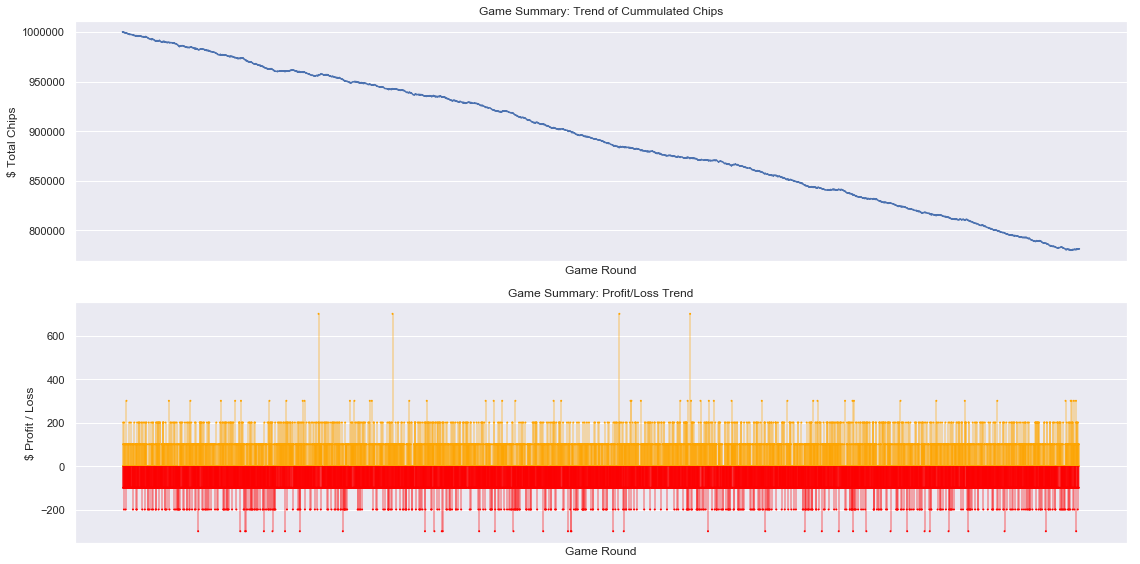

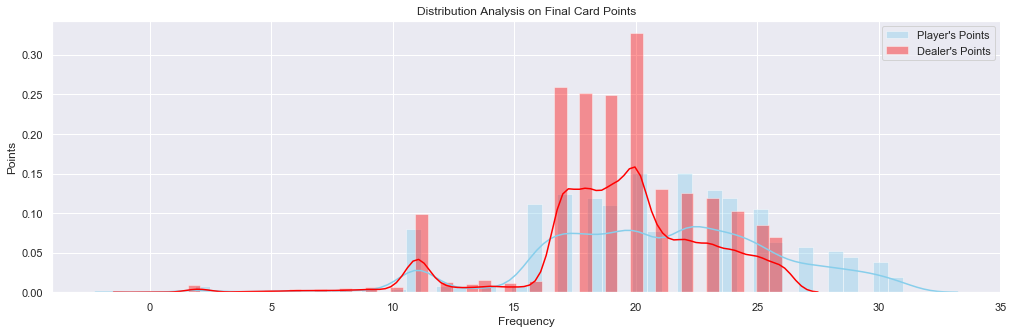

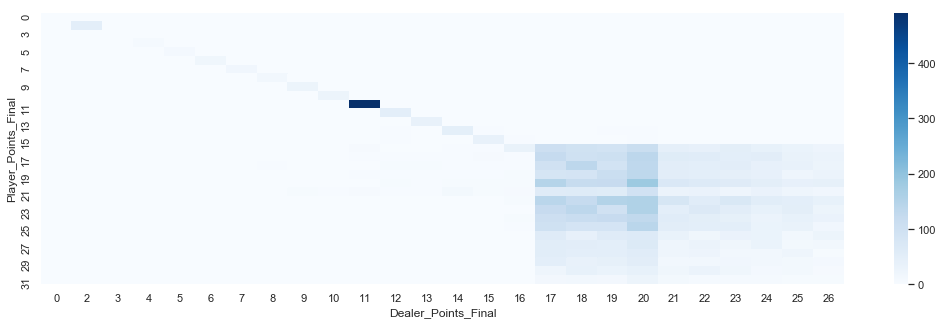

In [19]:
def game_summary(total_chips = total_chips, LnP = LnP, bid_lst = bid_lst,player_pts_lst=player_pts_lst):
    df = pd.DataFrame(columns=["Total_Chips",'Profit&Loss'])
    df['Total_Chips'] = total_chips
    df['Profit&Loss'] = LnP
    df['Bid_input'] = bid_lst
    df['Player_Points_Final'] = player_pts_lst
    df['Dealer_Points_Final'] = deal_pts_lst
    df['Result'] = df['Profit&Loss'].apply(lambda x : "Win" if x > 0 else ( "Lose" if x <0 else "Draw" ))
    df['Natural_win'] = abs(df['Profit&Loss']) / df['Bid_input']>1
    
    nat_win = df[df['Natural_win']==True]['Natural_win'].count()
    overall = (len(df)-1) 
    no_of_lose = df[df['Result']=="Lose"]['Result'].count()
    no_of_win = df[df['Result']=="Win"]['Result'].count()
    no_of_draw = df[df['Result']=="Draw"]['Result'].count() -1
    initial_chp = df['Total_Chips'][0]
    final_chp = df['Total_Chips'][len(df)-1]
    earning = df['Profit&Loss'].sum()


    print("   ======================= GAME SUMMARY =======================")
    print('\n')
    print(f'   Number of games       : {overall}        Winning Probability: {(no_of_win *100 / overall):.2f} %')
    print(f'   Number of games WON   : {no_of_win}         Initial Chips      : $ {initial_chp}')
    print(f'   Number of games LOST  : {no_of_lose}         Final Chips        : $ {final_chp}')
    print(f'   Number of games DRAW  : {no_of_draw}         Total Earning/Loss : $ {earning}')
    print(f'   Number of Natural WIN : {nat_win}')
    
    ## Plot Graph
    
    fig, ax = plt.subplots(2,1,figsize = (16,8))
    sns.set()
    a = ax.flatten()

    y1 = df['Total_Chips']
    y2= df['Profit&Loss']
    x2 = list(df.index)
    
    if len(x2)>100:
        x3 = []
    else: x3 = x2
    
    a[0].plot(y1)
    ax[0].set_xticks(x3)

    a[0].set_title("Game Summary: Trend of Cummulated Chips", loc='center')
    a[0].set_xlabel('Game Round')
    a[0].set_ylabel('$ Total Chips')

    my_color=np.where(y2>=0, 'orange', 'red')
    plt.vlines(x=x2, ymin=0, ymax=y2, color=my_color, alpha=0.4)
    plt.scatter(x2, y2, color=my_color, s=1, alpha=1)
    ax[1].set_xticks(x3)

    a[1].set_title("Game Summary: Profit/Loss Trend", loc='center')
    a[1].set_xlabel('Game Round')
    a[1].set_ylabel('$ Profit / Loss')
    
    
    fig2, ax2 = plt.subplots(figsize = (17,5))
    sns.distplot( df["Player_Points_Final"] , color="skyblue", label="Player's Points")
    sns.distplot( df["Dealer_Points_Final"] , color="red", label="Dealer's Points")
    ax2.set_title('Distribution Analysis on Final Card Points')
    ax2.set_ylabel("Points")
    ax2.set_xlabel("Frequency")
    
    fig3, ax3 = plt.subplots(figsize = (18,5))
    sns.heatmap(pd.crosstab(df['Player_Points_Final'],df['Dealer_Points_Final']), cmap = "Blues")
    
    fig.tight_layout()
    ax2.legend()
    plt.show()
    
    return df

df = game_summary(total_chips = total_chips, LnP = LnP, bid_lst = bid_lst,player_pts_lst=player_pts_lst)

Let's see the trained Q-values:

For example:
(19, 10, False): {1: -0.655, 0: -0.077} << extracted from one of the Q-values

This would mean next time, if the bot has "player hand = 19", "one of the dealer card show 10", "no useable ace", the model will go for STAND (action 0), as action 0 is larger than action 1.


In [20]:
player.player_Q_Values

{(11, 1, True): {1: 0, 0: 0},
 (11, 1, False): {1: 0, 0: 0},
 (11, 2, True): {1: 0, 0: 0},
 (11, 2, False): {1: 0, 0: 0},
 (11, 3, True): {1: 0, 0: 0},
 (11, 3, False): {1: 0, 0: 0},
 (11, 4, True): {1: 0, 0: 0},
 (11, 4, False): {1: 0, 0: 0},
 (11, 5, True): {1: 0, 0: 0},
 (11, 5, False): {1: 0, 0: 0},
 (11, 6, True): {1: 0, 0: 0},
 (11, 6, False): {1: 0, 0: 0},
 (11, 7, True): {1: 0, 0: 0},
 (11, 7, False): {1: 0, 0: 0},
 (11, 8, True): {1: 0, 0: 0},
 (11, 8, False): {1: 0, 0: 0},
 (11, 9, True): {1: 0, 0: 0},
 (11, 9, False): {1: 0, 0: 0},
 (11, 10, True): {1: 0, 0: 0},
 (11, 10, False): {1: 0, 0: 0},
 (12, 1, True): {1: 0, 0: 0},
 (12, 1, False): {1: -0.569, 0: 0},
 (12, 2, True): {1: 0, 0: 0},
 (12, 2, False): {1: -0.491, 0: 0},
 (12, 3, True): {1: 0, 0: 0},
 (12, 3, False): {1: -0.453, 0: 0},
 (12, 4, True): {1: 0, 0: 0},
 (12, 4, False): {1: -0.624, 0: 0},
 (12, 5, True): {1: 0, 0: 0},
 (12, 5, False): {1: -0.554, 0: 0},
 (12, 6, True): {1: 0, 0: 0},
 (12, 6, False): {1: -0.422,

With this trained Q-values, let's run another 10000 rounds of games to see what is our winning rates.

For this case, I'm going to change the bidding amount from 100 dollar to 500 dollar, and set our starting cash to be 10,000 dollar, to be reasonable. I am also changing the exp_rate to 0, such that our model will rely on trained Q-values completely to determine its action.

In [28]:
vers = 2.00
player.build_deck()
actual_deck = player.full_deck.copy()
player.lr = 0.1
player.exp_rate = 0 #action completely based on Q-values

# for Data collection
total_chips = [50000] #starting
bid_lst = [0]
LnP = [0]
player_pts_lst = [0]
deal_pts_lst = [0]

print(f"$$$ You have starting cash of ${total_chips[-1]}")

for i in range(0,500):
    player.reset()
    # DECK SHUFFLE - only shuffle when 70% of card is consumed
    if len(actual_deck)/52 <= 0.3:
        random.shuffle(player.full_deck)
        actual_deck = player.full_deck.copy()   
    else: random.shuffle(actual_deck)   
    
    # Bidding input verification
    #bid = input("How much do you want to bid? : ")
    bid = "500"
    while sum([ 1 for j in bid if j not in "0123456789"])>0:
        print("Please enter valid integer.")
        bid = input("How much do you want to bid? : ")
        continue
    bid = eval(bid)
    while bid > total_chips[-1]:
        print("You have no money...")
        bid = input("How much do you want to bid? : ")
        bid = eval(bid)
        continue
    bid_lst.append(bid)
    
    print("\n")
    print(f"************************** Round {i+1} **************************")
    print(f"$$$ You have bidded ${bid}!")
    print(f"$$$ You have remaining ${total_chips[-1] - bid_lst[-1]}!")
    print("\n")
    print(colored("--- Player's Turn ---", 'blue'))
    player_hand = draw_hand(actual_deck)
    dealer_hand = draw_hand(actual_deck)
    play_pts = calculate_pts(player_hand)
    deal_pts = calculate_pts(dealer_hand)
    print(f"You got: {player_hand}")
    
    player.state = max(play_pts), dealer_hand[0] if type(dealer_hand[0]) == int else min(calculate_pts(dealer_hand[0])),True if len(play_pts)>1 else False
    
    # Check for Natural Win
    player.natural_win_player(player_deck = player_hand)
    player.natural_win_dealer(dealer_deck = dealer_hand)
    if player.end_game == True:
        pay = player.natural_winner(bid)
        total_chips.append(total_chips[-1]+pay)
        LnP.append(pay)
        player_pts_lst.append(min(play_pts)) # data collection
        deal_pts_lst.append(min(play_pts)) # data collection
        continue
        
    # Continue if no Natural Win
    # ------------------------------- PLAYER TURN ----------------------------------
    if not player.end_game:
        play_pts = calculate_pts(player_hand)
        display_pts(play_pts)   
        
        action = player.chooseAction()
        if max(play_pts)>11:
            player.player_state_action.append([player.state, action])

        while action and min(play_pts)<=21 and not player.end_turn:
            player_hand = draw_card(actual_deck,player_hand)
            play_pts = calculate_pts(player_hand)
            print(f"You got: {player_hand}")
            display_pts(play_pts)
            player.natural_win_player(player_deck = player_hand)
            if player.end_game == True:
                pay = player.natural_winner(bid)
                break
            if max(play_pts)<=21:
                player.state = max(play_pts), dealer_hand[0] if type(dealer_hand[0]) == int else min(calculate_pts(dealer_hand[0])),True if len(play_pts)>1 else False
                action = player.chooseAction()
        
    # ------------------------------- DEALER TURN ----------------------------------
    if not player.end_game:
        print(colored("--- Dealer's Turn ---", 'red'))      
        while max(deal_pts) < 17 and len(dealer_hand)<5:
            dealer_hand = draw_card(actual_deck,dealer_hand)
            print("Dealer drew a card...")
            deal_pts = calculate_pts(dealer_hand)
            player.natural_win_dealer(dealer_deck = dealer_hand)
            if player.end_game == True:
                pay = player.natural_winner(bid)
                break
        
        play_pts = max(play_pts)
        deal_pts = max(deal_pts)
        print(f"Dealer got : {dealer_hand}")
        print(f"Dealer have total of {deal_pts}.")
        print("\n")
        result = compare(play_pts, deal_pts)
        pay = player.winner(result, bid)
        player.end_game = True
        print("\n")
    
    play_pts = max(calculate_pts(player_hand))
    deal_pts = max(calculate_pts(dealer_hand))
    LnP.append(pay)
    total_chips.append(total_chips[-1]+pay)
    player_pts_lst.append(play_pts) # data collection
    deal_pts_lst.append(deal_pts) # data collection

    if not player.player_natwin or not player.dealer_natwin:
        player._giveCredit(play_pts, deal_pts)
   
    #cont_ = input("Continue to next round? Y/N :")
    cont_ = 'y'
    while cont_.lower() not in "yn":
        print("Invalid input. Please enter Y/N.")
        cont_ = input("Continue to next round? Y/N :")   
    if cont_.lower() == 'y':
        continue
    elif cont_.lower() == 'n':
        print("Game ended.")
        # see result
        break

$$$ You have starting cash of $50000


************************** Round 1 **************************
$$$ You have bidded $500!
$$$ You have remaining $49500!


--- Player's Turn ---
You got: [3, 2]
You have total of 5.
You got: [3, 2, 'K']
You have total of 15.
You got: [3, 2, 'K', 'J']
You have total of 25.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [6, 7, 7]
Dealer have total of 20.


YOU LOST! $-500 to your stash.




************************** Round 2 **************************
$$$ You have bidded $500!
$$$ You have remaining $49000!


--- Player's Turn ---
You got: [2, 7]
You have total of 9.
You got: [2, 7, 10]
You have total of 19.
greedy action 1
greedy action 0
--- Dealer's Turn ---
Dealer got : [7, 'Q']
Dealer have total of 17.


YOU WON! $500 to your stash.




************************** Round 3 **************************
$$$ You have bidded $500!
$$$ You have remaining $49500!


--- Player's Turn ---
You got: ['Q', 'Q']
You have total of 20.
greedy action 1
gr

YOU WON! $500 to your stash.




************************** Round 87 **************************
$$$ You have bidded $500!
$$$ You have remaining $53000!


--- Player's Turn ---
You got: [3, 3]
You have total of 6.
You got: [3, 3, 'Q']
You have total of 16.
greedy action 1
You got: [3, 3, 'Q', 'J']
You have total of 26.
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [4, 'J', 4]
Dealer have total of 18.


YOU LOST! $-500 to your stash.




************************** Round 88 **************************
$$$ You have bidded $500!
$$$ You have remaining $52500!


--- Player's Turn ---
You got: [8, 'K']
You have total of 18.
greedy action 1
greedy action 0
--- Dealer's Turn ---
Dealer got : [9, 'A']
Dealer have total of 20.


YOU LOST! $-500 to your stash.




************************** Round 89 **************************
$$$ You have bidded $500!
$$$ You have remaining $52000!


--- Player's Turn ---
You got: [3, 10]
You have total of 13.
You got: [3, 10, 2]
You have total of 15.
Y

greedy action 0
--- Dealer's Turn ---
Dealer got : [7, 'K']
Dealer have total of 17.


YOU WON! $500 to your stash.




************************** Round 168 **************************
$$$ You have bidded $500!
$$$ You have remaining $59500!


--- Player's Turn ---
You got: [2, 7]
Dealer got Ban Luck!
YOU LOST! $-1000 to your stash.


************************** Round 169 **************************
$$$ You have bidded $500!
$$$ You have remaining $58500!


--- Player's Turn ---
You got: ['A', 9]
You have total of 10 or 20.
greedy action 1
greedy action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : ['Q', 5, 6]
Dealer have total of 21.


YOU LOST! $-500 to your stash.




************************** Round 170 **************************
$$$ You have bidded $500!
$$$ You have remaining $58000!


--- Player's Turn ---
You got: [8, 4]
You have total of 12.
You got: [8, 4, 5]
You have total of 17.
greedy action 1
You got: [8, 4, 5, 3]
You have total of 20.
greedy action 1
greedy act


YOU LOST! $-500 to your stash.




************************** Round 248 **************************
$$$ You have bidded $500!
$$$ You have remaining $66500!


--- Player's Turn ---
You got: [7, 7]
You have total of 14.
You got: [7, 7, 'K']
You have total of 24.
--- Dealer's Turn ---
Dealer got : [8, 10]
Dealer have total of 18.


YOU LOST! $-500 to your stash.




************************** Round 249 **************************
$$$ You have bidded $500!
$$$ You have remaining $66000!


--- Player's Turn ---
You got: [7, 3]
You have total of 10.
You got: [7, 3, 'J']
You have total of 20.
greedy action 1
greedy action 0
--- Dealer's Turn ---
Dealer got : ['A', 9]
Dealer have total of 20.


IT IS A DRAW!




************************** Round 250 **************************
$$$ You have bidded $500!
$$$ You have remaining $66000!


--- Player's Turn ---
You got: [3, 'A']
You have total of 4 or 14.
You got: [3, 'A', 3]
You have total of 7 or 17.
greedy action 1
greedy action 0
--- Dealer's Tur

You have total of 15.
You got: [9, 6, 3]
You have total of 18.
greedy action 1
greedy action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer drew a card...
Dealer got : [2, 4, 5, 2, 'K']
Dealer have total of 23.


YOU WON! $500 to your stash.




************************** Round 334 **************************
$$$ You have bidded $500!
$$$ You have remaining $63500!


--- Player's Turn ---
You got: [6, 10]
You have total of 16.
greedy action 1
greedy action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [2, 6, 3, 7]
Dealer have total of 18.


YOU LOST! $-500 to your stash.




************************** Round 335 **************************
$$$ You have bidded $500!
$$$ You have remaining $63000!


--- Player's Turn ---
You got: [9, 'J']
You have total of 19.
greedy action 1
greedy action 0
--- Dealer's Turn ---
Dealer got : ['K', 9]
Dealer have total of 19.


IT IS A DRAW!




************************** Round 336 *************

Dealer drew a card...
Dealer got : [4, 2, 5, 8]
Dealer have total of 19.


YOU WON! $500 to your stash.




************************** Round 425 **************************
$$$ You have bidded $500!
$$$ You have remaining $71500!


--- Player's Turn ---
You got: [3, 'J']
You have total of 13.
You got: [3, 'J', 6]
You have total of 19.
greedy action 1
greedy action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer got : [2, 7, 10]
Dealer have total of 19.


IT IS A DRAW!




************************** Round 426 **************************
$$$ You have bidded $500!
$$$ You have remaining $71500!


--- Player's Turn ---
You got: [7, 'Q']
You have total of 17.
greedy action 1
greedy action 0
--- Dealer's Turn ---
Dealer drew a card...
Dealer drew a card...
Dealer got : [5, 5, 5, 9]
Dealer have total of 24.


YOU WON! $500 to your stash.




************************** Round 427 **************************
$$$ You have bidded $500!
$$$ You have remaining $72000!


--- Player's Turn ---
You g

### Game Summary (using trained Q Value)

As you can see the winning odds has become around 42-46%, which is a good odds to win against your dealer in the long run. Try out more runs your self and you will realize you are always in the profit region.

   ======================= GAME SUMMARY =======================


   Number of games       : 500        Winning Probability: 43.60 %
   Number of games WON   : 218         Initial Chips      : $ 50000
   Number of games LOST  : 193         Final Chips        : $ 72000
   Number of games DRAW  : 89         Total Earning/Loss : $ 22000
   Number of Natural WIN : 57


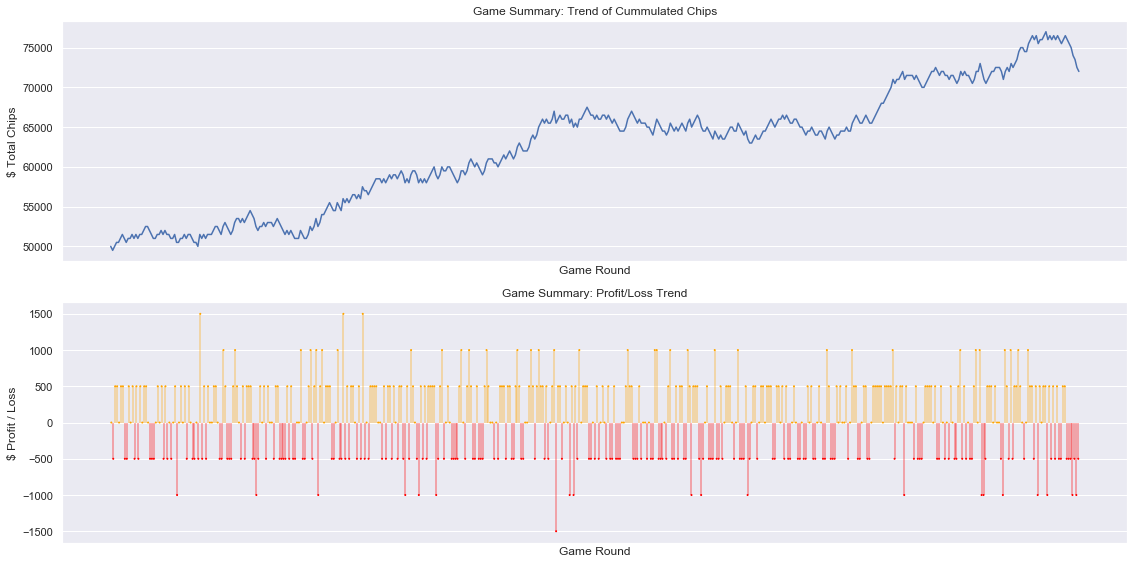

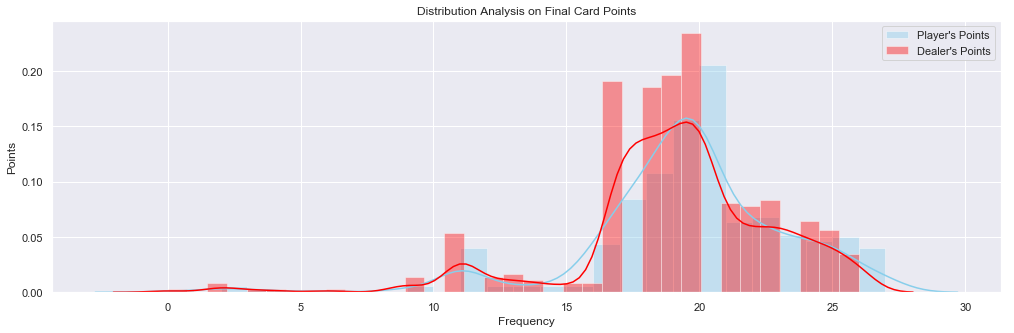

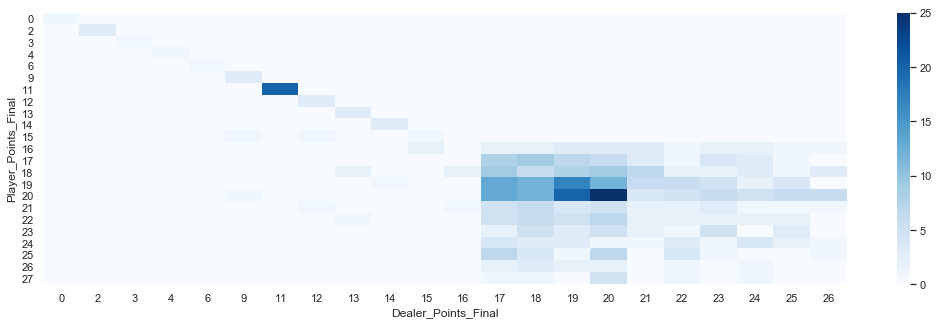

In [29]:
def game_summary(total_chips = total_chips, LnP = LnP, bid_lst = bid_lst,player_pts_lst=player_pts_lst):
    df = pd.DataFrame(columns=["Total_Chips",'Profit&Loss'])
    df['Total_Chips'] = total_chips
    df['Profit&Loss'] = LnP
    df['Bid_input'] = bid_lst
    df['Player_Points_Final'] = player_pts_lst
    df['Dealer_Points_Final'] = deal_pts_lst
    df['Result'] = df['Profit&Loss'].apply(lambda x : "Win" if x > 0 else ( "Lose" if x <0 else "Draw" ))
    df['Natural_win'] = abs(df['Profit&Loss']) / df['Bid_input']>1
    
    nat_win = df[df['Natural_win']==True]['Natural_win'].count()
    overall = (len(df)-1) 
    no_of_lose = df[df['Result']=="Lose"]['Result'].count()
    no_of_win = df[df['Result']=="Win"]['Result'].count()
    no_of_draw = df[df['Result']=="Draw"]['Result'].count() -1
    initial_chp = df['Total_Chips'][0]
    final_chp = df['Total_Chips'][len(df)-1]
    earning = df['Profit&Loss'].sum()


    print("   ======================= GAME SUMMARY =======================")
    print('\n')
    print(f'   Number of games       : {overall}        Winning Probability: {(no_of_win *100 / overall):.2f} %')
    print(f'   Number of games WON   : {no_of_win}         Initial Chips      : $ {initial_chp}')
    print(f'   Number of games LOST  : {no_of_lose}         Final Chips        : $ {final_chp}')
    print(f'   Number of games DRAW  : {no_of_draw}         Total Earning/Loss : $ {earning}')
    print(f'   Number of Natural WIN : {nat_win}')
    
    ## Plot Graph
    
    fig, ax = plt.subplots(2,1,figsize = (16,8))
    sns.set()
    a = ax.flatten()

    y1 = df['Total_Chips']
    y2= df['Profit&Loss']
    x2 = list(df.index)
    
    if len(x2)>100:
        x3 = []
    else: x3 = x2
    
    a[0].plot(y1)
    ax[0].set_xticks(x3)

    a[0].set_title("Game Summary: Trend of Cummulated Chips", loc='center')
    a[0].set_xlabel('Game Round')
    a[0].set_ylabel('$ Total Chips')

    my_color=np.where(y2>=0, 'orange', 'red')
    plt.vlines(x=x2, ymin=0, ymax=y2, color=my_color, alpha=0.4)
    plt.scatter(x2, y2, color=my_color, s=1, alpha=1)
    ax[1].set_xticks(x3)

    a[1].set_title("Game Summary: Profit/Loss Trend", loc='center')
    a[1].set_xlabel('Game Round')
    a[1].set_ylabel('$ Profit / Loss')
    
    
    fig2, ax2 = plt.subplots(figsize = (17,5))
    sns.distplot( df["Player_Points_Final"] , color="skyblue", label="Player's Points")
    sns.distplot( df["Dealer_Points_Final"] , color="red", label="Dealer's Points")
    ax2.set_title('Distribution Analysis on Final Card Points')
    ax2.set_ylabel("Points")
    ax2.set_xlabel("Frequency")
    
    fig3, ax3 = plt.subplots(figsize = (18,5))
    sns.heatmap(pd.crosstab(df['Player_Points_Final'],df['Dealer_Points_Final']), cmap = "Blues")
    
    fig.tight_layout()
    ax2.legend()
    plt.show()
    
    return df

df = game_summary(total_chips = total_chips, LnP = LnP, bid_lst = bid_lst,player_pts_lst=player_pts_lst)

DISCLAIMER: Do not use this on actual Casino. Dealer (bot) in this simulation environment is with a prefixed policy with fixed winning rate by probability. Actual dealer in Casino maybe following different sets of rules, and using a trained Q-values to bet your hard-earned money may not be a good idea.

### Enjoy Gambling!